# Library design for CTP-04, whole Chr21 tracing

by Pu Zheng and Jun-Han Su

This library design is for human chr21 tracing at 50 kb resolution

In [1]:
#minimum imports:
import time,os,sys,glob
import cPickle as pickle
import numpy as np
import khmer
sys.path.append(r'/n/home13/pzheng/Documents/python-functions/python-functions-library')

from LibraryConstruction import fastaread,fastawrite,fastacombine
import LibraryDesigner as ld
import LibraryConstruction as lc

## 1 Extract region sequences

In [2]:
## Some folders
# human genome
master_dir = r'/n/boslfs/LABS/zhuang_lab/User/pzheng'
genome_folder = master_dir + os.sep + r'Genomes/human/hg38/chroms';

### 1.1 Chr21

In [6]:
def Batch_Extract_Sequences(reg_dir, reg_filename =r'Regions.txt', \
                            genome_dir=r'Genomes/human/hg38/chroms',\
                            save_dir=r'region_seqs',\
                            master_dir=r'/n/boslfs/LABS/zhuang_lab/User/pzheng',\
                            merge=True, save=True, resolution=10000, flanking=100000):
    '''Function to extract sequences for all regions written in a file
    Given:
    
    merge: if merge all regions together and arrange region id, bool'''
    genome_folder = master_dir + os.sep + genome_dir; # get genome folder full path
    region_folder = master_dir + os.sep + reg_dir;
    save_folder = region_folder + os.sep + save_dir;
    if not isinstance(region_folder, str) and not isinstance(reg_filename, str) \
        and not isinstance(genome_folder, str):
        raise ValueError('wrong input format!');

    def read_region_file(region_folder=region_folder, reg_filename=reg_filename):
        '''Sub-function to read region file'''
        # region filename
        _reg_filename = region_folder + os.sep + reg_filename;
        _reg_file = open(_reg_filename, 'r');    
        print 'Input region file is: '+ _reg_filename;
        # start reading
        _lines = _reg_file.read().split('\n')
        _titles = _lines[0].split('\t');
        # save a list of dictionaries
        _reg_list = [];
        for _line in _lines[1:]:
            _reg_dic = {}; # dinctionary to save all informations
            _info = _line.split('\t'); # split informations
            if len(_info) != len(_titles): # sanity check to make sure they are of the same size
                continue;
            for _i in range(len(_info)): # save info to dic
                _reg_dic[_titles[_i]] = _info[_i];
            _reg_list.append(_reg_dic); # save dic to list
        _reg_file.close();
        return _reg_list

    def parse_region(reg_dic):
        '''given a dictionary of one region, 
        report:
            _chrom: str
            _start: int
            _stop: int'''
        region_str = reg_dic['Region'];
        # grab chromosome
        _chrom = region_str.split(':')[0];
        _locus = region_str.split(':')[1];
        # grab start and stop positions
        _start, _stop = _locus.split('-')
        _start = int(_start.replace(',', ''));
        _stop = int(_stop.replace(',', ''));
        # return in this order:
        return _chrom, _start, _stop
    
    def extract_sequence(reg_dic, genome_folder=genome_folder, \
                         resolution=resolution, flanking=flanking, \
                         save_folder=save_folder, save=save, merge=merge):
        from math import ceil
        '''sub-function to extract sequences of one locus
        Given:
        reg_dic: dic for region info, dictionary
        genome_folder: dir for genome files, str
        resolution: resolution of each region in bp, int
        flanking: upstream and downstream included in bp, int
        save: if save as fasta files, bool
        Return:
        dic of sequences of designed regions
        Dependencies:
        ld.fastaread, ld.fastawrite, ./parse_region'''
        # get chromosome, start and stop information
        _chrom, _start, _stop = parse_region(reg_dic);
        # dir to store sequences, this will be returned
        _seq_dic = {};
        _seqs = []
        _names = []
        if not flanking:
            flanking=0;
        # read chromosome seq
        _, _wholechr = ld.fastaread(genome_folder+os.sep+_chrom+'.fa')
        _wholechr = _wholechr[0];
        # number of regions
        _n_reg = int(ceil( float(_stop+flanking - (_start-flanking)) / resolution))
        # extract all required seq
        _whole_seq = _wholechr[_start-flanking: min(_start-flanking+_n_reg*resolution, len(_wholechr))];
        for _i in range(_n_reg):
            # extract sequence for this region
            if len(_whole_seq) < (_i+1)*resolution:
                break;
            _seq = _whole_seq[_i*resolution:(_i+1)*resolution];
            _name = _chrom+':'+str(_start-flanking+_i*resolution)+'-'+\
                     str(_start-flanking+(_i+1)*resolution)+'_reg_'+str(_i+1);
            _seq_dic[_name] = _seq;
            _seqs.append(_seq);
            _names.append(_name);
        # if Save
        if save:                
            # mkdir if not exist for save folder
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
                
            print '-writing region number:' + str(_n_reg);
            
            if merge: # NOTICE! this will never overwrite!
                save_sub_folder = save_folder+os.sep+'merged';
                if not os.path.exists(save_sub_folder):
                    os.makedirs(save_sub_folder)
                ex_file_num = len(glob.glob(save_sub_folder+os.sep+r'*'));
                # writing files
                for _i in range(_n_reg):
                    _filename = save_sub_folder + os.sep + 'reg_' + str(ex_file_num+_i+1) + '.fasta';
                    # save as fasta
                    if 'Gene' in reg_dic.keys():
                        ld.fastawrite(_filename, [_names[_i]+'_gene_'+reg_dic['Gene']], [_seqs[_i].upper()])
                    else:
                        ld.fastawrite(_filename, [_names[_i]], [_seqs[_i].upper()])
                print 'Number of region: '+str(len(glob.glob(save_sub_folder+os.sep+r'*')));
            else:
                # assign correct name of the sub folder
                if 'Gene' in reg_dic.keys():
                    save_sub_folder = save_folder+os.sep+reg_dic['Gene'];
                else:
                    save_sub_folder = save_folder+os.sep+_chrom+str(_start);
                # mkdir if not exist for this region
                if not os.path.exists(save_sub_folder):
                    os.makedirs(save_sub_folder)
                # writing files
                for _i in range(_n_reg):
                    _filename = save_sub_folder + os.sep + 'reg_' + str(_i+1) + '.fasta';
                    # save as fasta
                    ld.fastawrite(_filename, [_names[_i]], [_seqs[_i].upper()])
                
        return _seq_dic
        
    ## read region file
    reg_list = read_region_file();
    
    # extract sequences and save!
    seq_dic_list = [];
    for reg_dic in reg_list:
        seqs = extract_sequence(reg_dic, save=True)
        seq_dic_list.append(seqs);
        
    return seq_dic_list, reg_list
        

## 1.2 write information for parsing whole chromosome 21 

In [7]:
## write a region file
# environment
master_dir = r'/n/boslfs/LABS/zhuang_lab/User/pzheng';
region_dir = r'Libraries/CTP-04/chr21';
region_folder = master_dir + os.sep + region_dir;
reg_filename =r'Regions.txt'
res = 50000 # 50kb resolution
# make dir if not exist
if not os.path.exists(region_folder):
    os.makedirs(region_folder)
# information which is going to be writted into region file
region_titles = ['Gene', 'Region', 'Strand'];
region_infos = ['chr21', 'chr21:1-46709983', '+'];
# writing information!
with open(region_folder+os.sep+reg_filename, 'w') as region_handle:
    for title in region_titles:
        region_handle.write(title+'\t');
    region_handle.write('\n');
    for info in region_infos:
        region_handle.write(info+'\t');    

## 1.3 start parsing chr21!

In [ ]:
## Split the sequence!
seq_dic_list, reg_list = Batch_Extract_Sequences(reg_dir=region_dir,
                                                 reg_filename = reg_filename,
                                                 master_dir=master_dir,
                                                 resolution=res, flanking=0,
                                                 merge=True, save=True)

# 2 Design Probes

In [2]:
##Construct SI15 probes-whole_chr21
import time,os,sys
reload(ld)
import matplotlib.pyplot as plt
plt.switch_backend('agg')

# Indeces
index_folder = r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Indeces/human/hg38';
genmoe_index = index_folder + os.sep + r'full_word17_.kmer';
repeat_index = index_folder + os.sep + r'HumanRepeats_word17_.kmer';
transcriptome_index = index_folder + os.sep + r'transcriptome_word17_.kmer';
# Used directories
master_dir = r'/n/boslfs/LABS/zhuang_lab/User/pzheng';
region_dir = r'Libraries/SI-14/chr21';
region_folder = master_dir + os.sep + region_dir;
seq_dir = r'/region_seqs/merged'; # if merged previously
save_dir = r'/reports/merged'; # if merged
# get input and output 
input_files = glob.glob(region_folder+seq_dir+os.sep+r'*.fasta')
save_folder = region_folder + save_dir;

if not os.path.exists(save_folder):
    os.makedirs(save_folder);
# Loop through all input files
for in_file in input_files:
    #print in_file
    save_file = save_folder+os.sep+os.path.basename(in_file).replace('.fasta','.pbr')#'/pb_reports_reg_'+str(-i-1)+'.pbr'
    if not os.path.exists(save_file): # if probe report file doesnt exist
        
        local_genome_fl = in_file
        print in_file;
        pb_designer = ld.pb_reports_class(
            sequence_dic={'file':in_file,'use_revc':False,'use_kmer':True},
            map_dic={'genome':{'file':genmoe_index,'use_revc':True,'use_kmer':True},
                  'rep_genome':{'file':repeat_index,'use_revc':True,'use_kmer':True},
                  'local_genome':{'file':local_genome_fl,'force_list':True,'use_revc':True,'use_kmer':True}},
            save_file=save_file,
            params_dic={'word_size':17,'pb_len':42,'buffer_len':2,'max_count':2**16-1,'check_on_go':False,'auto':False},
            dic_check={('genome','local_genome'):75,'rep_genome':0,'gc':[0.25,0.85],'tm':70,'masks':['AAAAA','TTTTT','GGGGG','CCCCC']})

        pb_designer.computeOTmaps()
        pb_designer.compute_pb_report()
        pb_designer.perform_check_end()
        pb_designer.plots()
        print len(pb_designer.pb_reports_keep)

/n/home13/pzheng/.conda/envs/python27rc2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_679.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.389878035
Dealing with sequence: 1 out of 1
Time(s): 18.3869318962
Picking non-overlaping sequences.
Time(s): 2.52659511566
524
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_590.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.461247921
Dealing with sequence: 1 out of 1
Time(s): 18.6344828606
Picking non-overlaping sequences.
Time(s): 2.46805787086
679
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_513.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.257029057
Dealing with sequence: 1 out of 1
Time(s): 18.5

Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.251125813
Dealing with sequence: 1 out of 1
Time(s): 15.6100459099
Picking non-overlaping sequences.
Time(s): 0.013170003891
0
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_226.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.976577044
Dealing with sequence: 1 out of 1
Time(s): 18.7740101814
Picking non-overlaping sequences.
Time(s): 1.60553383827
0
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_813.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 141.158977985
Dealing with sequence: 1 out of 1
Time(s): 18.5131649971
Picking non-overlaping sequences.
Time(s): 2.38251304626
698
/n/boslfs/LABS/zhuang_lab

Setting attribute: map_rep_genome
Time(s): 136.250996113
Dealing with sequence: 1 out of 1
Time(s): 16.8290851116
Picking non-overlaping sequences.
Time(s): 0.416394948959
0
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_803.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.252839804
Dealing with sequence: 1 out of 1
Time(s): 18.7607409954
Picking non-overlaping sequences.
Time(s): 2.6052339077
593
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_303.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.259049892
Dealing with sequence: 1 out of 1
Time(s): 18.5523929596
Picking non-overlaping sequences.
Time(s): 2.37525200844
695
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_435.fasta
Setting attribute: m

Setting attribute: map_rep_genome
Time(s): 136.251792908
Dealing with sequence: 1 out of 1
Time(s): 18.2661659718
Picking non-overlaping sequences.
Time(s): 2.27699112892
704
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_24.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.263243914
Dealing with sequence: 1 out of 1
Time(s): 15.8017010689
Picking non-overlaping sequences.
Time(s): 0.0131690502167
0
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_150.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.316344976
Dealing with sequence: 1 out of 1
Time(s): 18.4984810352
Picking non-overlaping sequences.
Time(s): 3.37110590935
0
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_215.fasta
Setting attribute: ma

Setting attribute: map_rep_genome
Time(s): 136.251834154
Dealing with sequence: 1 out of 1
Time(s): 18.5849328041
Picking non-overlaping sequences.
Time(s): 2.50193881989
565
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_42.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.245271921
Dealing with sequence: 1 out of 1
Time(s): 15.6329967976
Picking non-overlaping sequences.
Time(s): 0.0129749774933
0
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_75.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.304481983
Dealing with sequence: 1 out of 1
Time(s): 15.6900758743
Picking non-overlaping sequences.
Time(s): 0.0126581192017
0
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_871.fasta
Setting attribute: m

Setting attribute: map_rep_genome
Time(s): 136.258798122
Dealing with sequence: 1 out of 1
Time(s): 18.8115999699
Picking non-overlaping sequences.
Time(s): 2.44052910805
616
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_227.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.256703138
Dealing with sequence: 1 out of 1
Time(s): 18.5029242039
Picking non-overlaping sequences.
Time(s): 1.48623013496
0
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_735.fasta
Setting attribute: map_local_genome
Mapping no. of seqs: 1
Setting attribute: map_genome
Setting attribute: map_rep_genome
Time(s): 136.285773993
Dealing with sequence: 1 out of 1
Time(s): 18.5215129852
Picking non-overlaping sequences.
Time(s): 2.3018488884
792
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/region_seqs/merged/reg_169.fasta
Setting attribute: ma

In [2]:
prob_lens = [];


# Used directories
master_dir = r'/n/boslfs/LABS/zhuang_lab/User/pzheng';
region_dir = r'Libraries/SI-14/chr21';
region_folder = master_dir + os.sep + region_dir;
save_dir = r'/reports/merged'; # if merged
# get previous outputs
save_folder = region_folder + save_dir;

#to continue or check sequences:
reload(ld)

pbde = ld.pb_reports_class()
files = glob.glob(save_folder+os.sep+r'*.pbr')
for file_ in files:
    pbde.load_pbr(file_)
    pbde.dic_check={'gc': [0.25, 0.85], 'rep_genome': 0, 'tm': 70, ('genome', 'local_genome'): 75,
                    'masks':['AAAAA','TTTTT','GGGGG','CCCCC']}
    pbde.perform_check_end()
    print file_
    print len(pbde.pb_reports_keep)
    prob_lens.append(len(pbde.pb_reports_keep))
    pbde.save_csv()
    #pbde.plots()

Picking non-overlaping sequences.
Time(s): 2.81264591217
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_343.pbr
435
Picking non-overlaping sequences.
Time(s): 2.92764377594
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_924.pbr
340
Picking non-overlaping sequences.
Time(s): 1.19924783707
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_253.pbr
0
Picking non-overlaping sequences.
Time(s): 1.61854696274
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_225.pbr
0
Picking non-overlaping sequences.
Time(s): 2.45497322083
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_703.pbr
672
Picking non-overlaping sequences.
Time(s): 2.78777194023
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_788.pbr
440
Picking non-overlaping sequences.
Time(s): 3.54409003258
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21

Picking non-overlaping sequences.
Time(s): 2.59776306152
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_752.pbr
578
Picking non-overlaping sequences.
Time(s): 2.38039398193
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_105.pbr
53
Picking non-overlaping sequences.
Time(s): 1.5715110302
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_235.pbr
0
Picking non-overlaping sequences.
Time(s): 2.38502788544
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_901.pbr
717
Picking non-overlaping sequences.
Time(s): 3.14430093765
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_266.pbr
221
Picking non-overlaping sequences.
Time(s): 2.10056591034
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_852.pbr
786
Picking non-overlaping sequences.
Time(s): 2.7023088932
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/

Picking non-overlaping sequences.
Time(s): 2.49071311951
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_730.pbr
666
Picking non-overlaping sequences.
Time(s): 2.49348402023
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_508.pbr
587
Picking non-overlaping sequences.
Time(s): 3.70148181915
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_137.pbr
7
Picking non-overlaping sequences.
Time(s): 2.20871591568
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_898.pbr
818
Picking non-overlaping sequences.
Time(s): 2.27172398567
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_302.pbr
769
Picking non-overlaping sequences.
Time(s): 2.6751999855
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_509.pbr
466
Picking non-overlaping sequences.
Time(s): 0.0231142044067
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/ch

Picking non-overlaping sequences.
Time(s): 2.62930893898
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_352.pbr
528
Picking non-overlaping sequences.
Time(s): 2.46579504013
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_627.pbr
628
Picking non-overlaping sequences.
Time(s): 1.62205505371
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_224.pbr
0
Picking non-overlaping sequences.
Time(s): 2.62391996384
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_456.pbr
503
Picking non-overlaping sequences.
Time(s): 0.0343029499054
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_61.pbr
0
Picking non-overlaping sequences.
Time(s): 2.47881197929
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_684.pbr
642
Picking non-overlaping sequences.
Time(s): 1.6695599556
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21

Picking non-overlaping sequences.
Time(s): 3.04843902588
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_561.pbr
255
Picking non-overlaping sequences.
Time(s): 2.67259192467
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_376.pbr
488
Picking non-overlaping sequences.
Time(s): 2.61385893822
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_403.pbr
487
Picking non-overlaping sequences.
Time(s): 2.51466679573
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_873.pbr
503
Picking non-overlaping sequences.
Time(s): 1.61630511284
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_228.pbr
0
Picking non-overlaping sequences.
Time(s): 2.54260802269
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_566.pbr
614
Picking non-overlaping sequences.
Time(s): 2.28124189377
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr

Picking non-overlaping sequences.
Time(s): 2.71261382103
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_572.pbr
461
Picking non-overlaping sequences.
Time(s): 2.55418920517
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_725.pbr
567
Picking non-overlaping sequences.
Time(s): 2.54547286034
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_442.pbr
515
Picking non-overlaping sequences.
Time(s): 0.0225172042847
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_25.pbr
0
Picking non-overlaping sequences.
Time(s): 3.05379199982
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_211.pbr
239
Picking non-overlaping sequences.
Time(s): 2.55560398102
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_666.pbr
592
Picking non-overlaping sequences.
Time(s): 3.44544196129
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/ch

Picking non-overlaping sequences.
Time(s): 2.70749902725
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_651.pbr
502
Picking non-overlaping sequences.
Time(s): 2.51432800293
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_886.pbr
589
Picking non-overlaping sequences.
Time(s): 3.3190369606
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_216.pbr
36
Picking non-overlaping sequences.
Time(s): 0.32174706459
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_206.pbr
7
Picking non-overlaping sequences.
Time(s): 0.0403280258179
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_16.pbr
0
Picking non-overlaping sequences.
Time(s): 2.3236579895
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_777.pbr
727
Picking non-overlaping sequences.
Time(s): 2.63854002953
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/r

Picking non-overlaping sequences.
Time(s): 2.32104492188
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_618.pbr
657
Picking non-overlaping sequences.
Time(s): 3.42059493065
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_273.pbr
15
Picking non-overlaping sequences.
Time(s): 2.69946599007
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_733.pbr
614
Picking non-overlaping sequences.
Time(s): 0.0226249694824
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_14.pbr
0
Picking non-overlaping sequences.
Time(s): 2.67073392868
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_490.pbr
552
Picking non-overlaping sequences.
Time(s): 2.8437640667
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_452.pbr
466
Picking non-overlaping sequences.
Time(s): 2.48525118828
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr2

Picking non-overlaping sequences.
Time(s): 3.0836930275
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_527.pbr
454
Picking non-overlaping sequences.
Time(s): 2.65674591064
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_932.pbr
522
Picking non-overlaping sequences.
Time(s): 2.64828205109
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_579.pbr
552
Picking non-overlaping sequences.
Time(s): 2.84106278419
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_408.pbr
514
Picking non-overlaping sequences.
Time(s): 0.941013097763
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_258.pbr
0
Picking non-overlaping sequences.
Time(s): 2.6303319931
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_722.pbr
587
Picking non-overlaping sequences.
Time(s): 2.37018895149
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr2

Picking non-overlaping sequences.
Time(s): 3.14967298508
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_670.pbr
213
Picking non-overlaping sequences.
Time(s): 0.0226969718933
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_86.pbr
0
Picking non-overlaping sequences.
Time(s): 3.51781702042
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_183.pbr
9
Picking non-overlaping sequences.
Time(s): 3.31676506996
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_559.pbr
216
Picking non-overlaping sequences.
Time(s): 2.83345913887
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_808.pbr
628
Picking non-overlaping sequences.
Time(s): 2.79837298393
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_745.pbr
634
Picking non-overlaping sequences.
Time(s): 0.893590927124
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr

Picking non-overlaping sequences.
Time(s): 2.55980801582
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_385.pbr
572
Picking non-overlaping sequences.
Time(s): 0.0232298374176
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_39.pbr
0
Picking non-overlaping sequences.
Time(s): 2.57783508301
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_892.pbr
585
Picking non-overlaping sequences.
Time(s): 2.26465892792
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_867.pbr
816
Picking non-overlaping sequences.
Time(s): 2.83774900436
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_574.pbr
549
Picking non-overlaping sequences.
Time(s): 2.34085297585
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_663.pbr
723
Picking non-overlaping sequences.
Time(s): 2.49465703964
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/ch

Picking non-overlaping sequences.
Time(s): 2.43525195122
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_819.pbr
627
Picking non-overlaping sequences.
Time(s): 2.87221002579
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_122.pbr
465
Picking non-overlaping sequences.
Time(s): 2.48886394501
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_379.pbr
626
Picking non-overlaping sequences.
Time(s): 2.42422604561
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_915.pbr
674
Picking non-overlaping sequences.
Time(s): 2.76491808891
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_416.pbr
562
Picking non-overlaping sequences.
Time(s): 2.43177890778
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_897.pbr
691
Picking non-overlaping sequences.
Time(s): 2.41969490051
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/c

Picking non-overlaping sequences.
Time(s): 2.84376120567
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_454.pbr
470
Picking non-overlaping sequences.
Time(s): 2.60018897057
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_641.pbr
668
Picking non-overlaping sequences.
Time(s): 2.4979391098
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_905.pbr
665
Picking non-overlaping sequences.
Time(s): 2.55341911316
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_481.pbr
590
Picking non-overlaping sequences.
Time(s): 2.64418506622
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_930.pbr
610
Picking non-overlaping sequences.
Time(s): 0.0234940052032
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_21.pbr
0
Picking non-overlaping sequences.
Time(s): 2.48844504356
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr

Picking non-overlaping sequences.
Time(s): 2.58467698097
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_431.pbr
542
Picking non-overlaping sequences.
Time(s): 2.52880907059
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_139.pbr
35
Picking non-overlaping sequences.
Time(s): 2.71021604538
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_396.pbr
540
Picking non-overlaping sequences.
Time(s): 2.42116618156
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_720.pbr
697
Picking non-overlaping sequences.
Time(s): 3.53836202621
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_208.pbr
147
Picking non-overlaping sequences.
Time(s): 2.45506000519
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_620.pbr
668
Picking non-overlaping sequences.
Time(s): 2.80419397354
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/ch

Picking non-overlaping sequences.
Time(s): 2.66685414314
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_818.pbr
619
Picking non-overlaping sequences.
Time(s): 2.55364990234
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_424.pbr
643
Picking non-overlaping sequences.
Time(s): 2.54493999481
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_571.pbr
638
Picking non-overlaping sequences.
Time(s): 2.84923005104
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_534.pbr
572
Picking non-overlaping sequences.
Time(s): 2.90951514244
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_933.pbr
593
Picking non-overlaping sequences.
Time(s): 2.71797394753
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_765.pbr
621
Picking non-overlaping sequences.
Time(s): 0.0359201431274
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15

Picking non-overlaping sequences.
Time(s): 3.49700713158
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_173.pbr
20
Picking non-overlaping sequences.
Time(s): 1.57119989395
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_148.pbr
0
Picking non-overlaping sequences.
Time(s): 3.31240200996
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_346.pbr
150
Picking non-overlaping sequences.
Time(s): 2.61012887955
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_610.pbr
606
Picking non-overlaping sequences.
Time(s): 3.05696415901
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_108.pbr
3
Picking non-overlaping sequences.
Time(s): 2.55576491356
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_604.pbr
671
Picking non-overlaping sequences.
Time(s): 2.81739997864
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/

Picking non-overlaping sequences.
Time(s): 2.49750089645
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_718.pbr
651
Picking non-overlaping sequences.
Time(s): 3.6289999485
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_126.pbr
0
Picking non-overlaping sequences.
Time(s): 2.52003502846
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_630.pbr
591
Picking non-overlaping sequences.
Time(s): 2.72608113289
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_675.pbr
490
Picking non-overlaping sequences.
Time(s): 2.36838197708
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_537.pbr
736
Picking non-overlaping sequences.
Time(s): 2.6082880497
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr21/reports/merged/reg_374.pbr
563
Picking non-overlaping sequences.
Time(s): 0.0226449966431
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/SI-15/chr

# 3. Post Processing

## 3.1 keep 500 probes in the center

In [32]:
# get previous outputs
max_pb_num = 500;
min_pb_num = 200;

# Used directories
region_folder=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21';
report_dir = r'/reports/merged'; # if merged
centered_save_dir = r'/reports/centered_merged'; # if merged


# Save directory
report_folder = region_folder + report_dir;
save_folder = region_folder + centered_save_dir+str(max_pb_num);
if not os.path.exists(save_folder):
    os.makedirs(save_folder);

# loop through all files
files = glob.glob(report_folder+os.sep+r'*.pbr')

for _file in sorted(files, key=lambda fl:int(fl.split('.pbr')[0].split('_')[-1])):
    
    if os.path.exists(save_folder + os.sep + os.path.basename(_file)):
        continue
    print _file
    # load probe report
    pbde = ld.pb_reports_class()
    pbde.load_pbr(_file)
    #change save file directory
    pbde.save_file = save_folder + os.sep + os.path.basename(pbde.save_file);
    # check length
    if len(pbde.pb_reports_keep) < min_pb_num:
        continue
    else:
        if len(pbde.pb_reports_keep) > max_pb_num:
            # get region length
            _start, _end = pbde.pb_reports_keep.values()[0]['reg_name'].split(':')[1].split('_')[0].split('-')
            _reg_len = int(_end) - int(_start)
            # initialize centered_dic
            centered_pb_dic = {}
            ct = 0;
            for key, value in sorted(pbde.pb_reports_keep.items(), key=lambda (k,v): abs(v['pb_index']-int(_reg_len/2))):
                centered_pb_dic[key] = value;
                ct += 1;
                if ct >= max_pb_num:
                    break
            pbde.pb_reports_keep = centered_pb_dic # during saving, its automatically sorted, so I didn't sort it again
        #pbde.save_csv()
        pbde.save_pbrs()
        pbde.plots()

/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_1.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_2.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_3.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_4.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_5.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_6.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_7.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_8.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_9.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_10.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_11.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-

/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_96.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_97.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_98.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_99.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_100.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_101.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_102.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_104.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_105.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_106.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_107.pbr
/n/boslfs/LABS/zhuang_lab/User/pzhen

/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_192.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_193.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_194.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_195.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_197.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_198.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_199.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_200.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_201.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_202.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_203.pbr
/n/boslfs/LABS/zhuang_lab/User/p

/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_288.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_289.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_290.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_292.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_293.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_295.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_296.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_298.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_299.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_300.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_301.pbr
/n/boslfs/LABS/zhuang_lab/User/p

/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_397.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_398.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_399.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_400.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_401.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_402.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_403.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_404.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_405.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_406.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_407.pbr
/n/boslfs/LABS/zhuang_lab/User/p

/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_496.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_498.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_500.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_501.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_502.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_503.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_504.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_505.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_506.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_507.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_511.pbr
/n/boslfs/LABS/zhuang_lab/User/p

/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_603.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_604.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_605.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_606.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_607.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_608.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_609.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_610.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_611.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_612.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_615.pbr
/n/boslfs/LABS/zhuang_lab/User/p

/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_719.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_720.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_721.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_722.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_723.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_724.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_725.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_726.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_727.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_728.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_729.pbr
/n/boslfs/LABS/zhuang_lab/User/p

/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_831.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_832.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_833.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_834.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_836.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_837.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_838.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_839.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_840.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_841.pbr
/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/merged/reg_842.pbr
/n/boslfs/LABS/zhuang_lab/User/p

## 3.2 Assign region into TADs

In [33]:
def Match_TADs(master_folder, TAD_ref, report_dir,
              verbose=True, save=True):
    '''Function to match regions with a TAD reference
    Input: 
    master_folder: master directory for the whole dataset, string
    TAD_ref: filename for TAD reference, string
    report_dir: directory for probe reports, string'''
    import os, glob, sys
    import LibraryDesigner as ld
    import numpy as np
    import cPickle as pickle
    
    def Read_TAD_ref(master_folder=master_folder, TAD_ref=TAD_ref):
        _tad_dics = [];
        with open(master_folder+os.sep+TAD_ref) as _ref_handle:
            _lines = _ref_handle.readlines();
            for _line in _lines:
                _chrom = _line.split(':')[0]
                _reg_str = _line.split(':')[1].split('\n')[0];
                _start,_stop = _reg_str.split('-');
                _tad_dic = {'chr':_chrom, 'start':int(_start), 'stop':int(_stop)}
                _tad_dics.append(_tad_dic);
        return sorted(_tad_dics, key=lambda d:d['start']);
    
    def Region_to_TAD(tad_dics, report_filename):
        _pb = ld.pb_reports_class()
        _pb.load_pbr(report_filename)
        # get its region status
        _reg_id = int(_pb.pb_reports_keep.values()[0]['reg_name'].split('reg')[1].split('_')[1])
        _chrom = _pb.pb_reports_keep.values()[0]['reg_name'].split(':')[0]
        _start, _stop = _pb.pb_reports_keep.values()[0]['reg_name'].split(':')[1].split('_')[0].split('-')
        _start = int(_start);
        _stop = int(_stop);
        if _start > _stop:
            _start, _stop = _stop, _start
        _reg_len = abs(_stop - _start)
        # initialize tad identity of this region
        _tad_id = -1;
        for i in range(len(tad_dics)):
            _dic = tad_dics[i];
            if _chrom == _dic['chr']:
                _overlap = min(_stop, _dic['stop']) - max(_start, _dic['start']);
                if _overlap > _reg_len / 2:
                    _tad_id = i; # assign tad id
                    break
    
        return _reg_id, _tad_id, len(_pb.pb_reports_keep)
    
    def Extra_Region_Assigning(tad_id_dic):
        '''Try to assign region to TADs as much as possible
        '''
        # calculate how many region has been assigned to each TAD
        _v,_c = np.unique(tad_id_dic.values(),return_counts=True)
        _reg_num_dic = dict(zip(_v,_c)) # dictionary for region number of each TAD

        # maximum gap size to be filled
        _gap_max = 4 

        # new_id_dic
        _new_id_dic = tad_id_dic.copy();

        # Starting filling gaps!
        _gap = 0;
        _prev_value = -1;
        for _key, _value in sorted(_new_id_dic.items()):
            # start a gap 
            if _gap == 0 and _value == -1: 
                _prev_tad = _prev_value
                _gap = 1; # turn on gap
                _key_ingap = [_key] # start recording keys in gap

            # continue a gap
            elif _gap == 1 and _value == -1:
                _key_ingap.append(_key)

            # stop a gap!
            elif _gap == 1 and _value > -1:
                _gap = 0; # stop counting gap
                _next_tad = _value 
                # if the gap is not huge, try to make up
                if len(_key_ingap) <= _gap_max: 
                    if _prev_tad == -1: # don't fill any gap at beginning
                        continue 
                    elif len(_key_ingap)/2*2 == len(_key_ingap): # gap size is even number
                        for i in range(len(_key_ingap)/2):
                            _new_id_dic[_key_ingap[i]] = _prev_tad
                            _new_id_dic[_key_ingap[i+len(_key_ingap)/2]] = _next_tad
                    else: # gap size is odd number
                        for i in range(len(_key_ingap)/2):
                            _new_id_dic[_key_ingap[i]] = _prev_tad
                            _new_id_dic[_key_ingap[i+len(_key_ingap)/2+1]] = _next_tad
                        if _reg_num_dic[_prev_tad] <= _reg_num_dic[_next_tad]:
                            _new_id_dic[_key_ingap[len(_key_ingap)/2]] = _prev_tad
                        else:
                            _new_id_dic[_key_ingap[len(_key_ingap)/2]] = _next_tad

            _prev_value = _value # store previous tad info

        return _new_id_dic   
    
    def Save_dics(master_folder, tad_dics, reg_len_dic, new_id_dic):
        # save tad dics
        tad_dic_file = open(master_folder+os.sep+'TAD_dic_list.pkl','w');
        pickle.dump(tad_dics, tad_dic_file);
        tad_dic_file.close()
        # save region length dic
        reg_len_dic_file = open(master_folder+os.sep+'region_length.pkl','w');
        pickle.dump(reg_len_dic, reg_len_dic_file);
        reg_len_dic_file.close()        
        # save region_to_tad dic
        reg_to_tad_file = open(master_folder+os.sep+'region_to_TAD.pkl','w');
        pickle.dump(new_id_dic, reg_to_tad_file);
        reg_to_tad_file.close() 

    if verbose:
        print '- Start reading TAD reference', TAD_ref
    tad_dics = Read_TAD_ref()
    print len(tad_dics)
    if verbose:
        print '- Start reading probe reports'
    report_folder = master_folder + os.sep + report_dir;
    files = glob.glob(report_folder+os.sep+r'*.pbr')
    tad_id_dic = {} # store assigned tad id
    reg_len_dic = {} # store number of probes in each region
    
    for _file in sorted(files, key=lambda fl:int(fl.split('.pbr')[0].split('_')[-1])):
        reg_id, tad_id, reg_len = Region_to_TAD(tad_dics, _file)
        tad_id_dic[reg_id] = tad_id; # update tad id dic
        reg_len_dic[reg_id] = reg_len; # update region length dic
        if verbose:
            print '--', os.path.basename(_file), 'tad_id:', tad_id, 'size:', reg_len

            
    new_id_dic = Extra_Region_Assigning(tad_id_dic)
    
    if save:
        Save_dics(master_folder=master_folder,
                 tad_dics=tad_dics,
                 reg_len_dic=reg_len_dic,
                 new_id_dic=new_id_dic);

    
    return tad_dics, tad_id_dic, reg_len_dic, new_id_dic
  

In [34]:
region_folder=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21';
report_dir = r'/reports/centered_merged'+str(max_pb_num); # if merged
save_folder = region_folder + report_dir;

tad_dics, tad_id_dic, reg_len_dic, new_id_dic= Match_TADs(region_folder,
                                                          TAD_ref='chr21_TADs.bed', 
                                                          report_dir=report_dir)

- Start reading TAD reference chr21_TADs.bed
34
- Start reading probe reports
-- reg_101.pbr tad_id: -1 size: 343
-- reg_102.pbr tad_id: -1 size: 399
-- reg_103.pbr tad_id: -1 size: 500
-- reg_121.pbr tad_id: -1 size: 370
-- reg_122.pbr tad_id: -1 size: 465
-- reg_123.pbr tad_id: -1 size: 454
-- reg_130.pbr tad_id: -1 size: 441
-- reg_131.pbr tad_id: -1 size: 257
-- reg_132.pbr tad_id: -1 size: 278
-- reg_156.pbr tad_id: -1 size: 363
-- reg_157.pbr tad_id: -1 size: 281
-- reg_195.pbr tad_id: -1 size: 216
-- reg_196.pbr tad_id: -1 size: 386
-- reg_209.pbr tad_id: 0 size: 215
-- reg_211.pbr tad_id: 0 size: 239
-- reg_213.pbr tad_id: 0 size: 216
-- reg_266.pbr tad_id: 1 size: 221
-- reg_281.pbr tad_id: 1 size: 464
-- reg_282.pbr tad_id: 1 size: 367
-- reg_283.pbr tad_id: 1 size: 500
-- reg_284.pbr tad_id: 1 size: 448
-- reg_285.pbr tad_id: 1 size: 500
-- reg_286.pbr tad_id: 1 size: 500
-- reg_287.pbr tad_id: 1 size: 500
-- reg_288.pbr tad_id: 1 size: 500
-- reg_289.pbr tad_id: 1 size: 334

-- reg_501.pbr tad_id: 5 size: 500
-- reg_502.pbr tad_id: 5 size: 500
-- reg_503.pbr tad_id: 5 size: 500
-- reg_504.pbr tad_id: 5 size: 500
-- reg_505.pbr tad_id: 5 size: 500
-- reg_506.pbr tad_id: 5 size: 500
-- reg_507.pbr tad_id: 5 size: 500
-- reg_508.pbr tad_id: 5 size: 500
-- reg_509.pbr tad_id: 5 size: 466
-- reg_510.pbr tad_id: 5 size: 500
-- reg_511.pbr tad_id: 5 size: 500
-- reg_512.pbr tad_id: 5 size: 500
-- reg_513.pbr tad_id: 5 size: 500
-- reg_514.pbr tad_id: 6 size: 500
-- reg_515.pbr tad_id: 6 size: 500
-- reg_516.pbr tad_id: 6 size: 500
-- reg_517.pbr tad_id: 6 size: 500
-- reg_518.pbr tad_id: 6 size: 500
-- reg_519.pbr tad_id: 6 size: 500
-- reg_520.pbr tad_id: 6 size: 500
-- reg_521.pbr tad_id: 6 size: 500
-- reg_522.pbr tad_id: 6 size: 500
-- reg_523.pbr tad_id: 6 size: 500
-- reg_524.pbr tad_id: 6 size: 500
-- reg_525.pbr tad_id: 6 size: 493
-- reg_526.pbr tad_id: 6 size: 500
-- reg_527.pbr tad_id: 6 size: 454
-- reg_528.pbr tad_id: 6 size: 500
-- reg_529.pbr tad_i

-- reg_732.pbr tad_id: 20 size: 500
-- reg_733.pbr tad_id: 20 size: 500
-- reg_734.pbr tad_id: 20 size: 500
-- reg_735.pbr tad_id: 20 size: 500
-- reg_736.pbr tad_id: 20 size: 500
-- reg_737.pbr tad_id: 20 size: 500
-- reg_738.pbr tad_id: 20 size: 500
-- reg_739.pbr tad_id: 20 size: 500
-- reg_740.pbr tad_id: 20 size: 500
-- reg_741.pbr tad_id: 20 size: 429
-- reg_742.pbr tad_id: 20 size: 500
-- reg_743.pbr tad_id: 20 size: 498
-- reg_744.pbr tad_id: 21 size: 500
-- reg_745.pbr tad_id: 21 size: 500
-- reg_746.pbr tad_id: 21 size: 500
-- reg_747.pbr tad_id: 21 size: 329
-- reg_748.pbr tad_id: 21 size: 500
-- reg_749.pbr tad_id: 21 size: 500
-- reg_750.pbr tad_id: 21 size: 500
-- reg_751.pbr tad_id: 21 size: 500
-- reg_752.pbr tad_id: 21 size: 500
-- reg_753.pbr tad_id: -1 size: 500
-- reg_754.pbr tad_id: 22 size: 500
-- reg_755.pbr tad_id: 22 size: 500
-- reg_756.pbr tad_id: 22 size: 500
-- reg_757.pbr tad_id: 22 size: 500
-- reg_758.pbr tad_id: 22 size: 500
-- reg_759.pbr tad_id: 22 si

## 3.3 Assign color and cluster id

In [37]:
def Generate_Encoding(master_folder, reg_id_dic,
                      total_encoding={}, sub_encoding={}, 
                      n_color=3, n_reg=10, n_hyb=5, min_region_times=2, 
                      sequential_for_nonencoding=True,
                      save=True, save_filename='other_encoding', verbose=True):
    '''Design encoding scheme for all excluded regions in total_encoding from sub_encoding
    Inputs:
        master_folder, directory for this library, string
        reg_id_dic: dictionary for region id -> tad id, dic
        total_encoding: dictionary for total encoding generated by previous code, if not given then design a new encoding dic
        sub_encoding: sub encoding in test experiment, if not given then design a new encoding dic
        n_color: number of colors, int
        n_reg: number of region per decoding unit, int
        n_hyb: number of hybes per decoding unit, int
        min_region_times: minimum region appearing times, int
        save: whether save final result, bool
        save_filename: filename of pickle file of this encoding scheme, string
        verbose: whether say something!, bool
    Outputs:
        other_encoding: region_number -> color=i, cluster=j, region=k, barcodes->...
        hyb_matrix: hybridization matrix, n_reg by n_hyb
        assign_regs: matrix of assigning region to clusters, n_color by n_cluster by n_reg
        assign_tads: matrix of assigning tad to clusters, n_color by n_cluster by n_reg
        '''
    
    def _Compare_Encodings(_total_encoding=total_encoding, _sub_encoding=sub_encoding, subset=True, _verbose=verbose):
        '''Function to compare two encoding scheme'''
        if _verbose:
            print "-- comparing two encoding schemes with size", len(_total_encoding.keys()),'and',len(_sub_encoding.keys())
        # check whether sub_encoding is really a subset of total_encoding
        for _k,_v in sorted(_sub_encoding.items()):
            if _k not in _total_encoding:
                if subset:
                    raise ValueError('-- key '+str(k)+' not exists in total encoding scheme')
                else:
                    raise Warning('-- key '+str(k)+' not exists in total encoding scheme')
        # extract existing regions
        _other_encoding = {}
        for _k,_v in sorted(_total_encoding.items()):
            if _k not in _sub_encoding:
                _other_encoding[_k] = _v
        
        return _other_encoding
                
    def _TAD_to_Region(reg_id_dic, _reg_encodings, _verbose=verbose):
        '''Function to inverse region->TAD dictionary'''
        if _verbose:
            print '-- Converting region->TAD dic into TAD->[regions]';
            
        _tad_to_region = {}
        for k, v in reg_id_dic.iteritems():
            if k in _reg_encodings:
                _tad_to_region[v] = _tad_to_region.get(v, [])
                _tad_to_region[v].append(k)   
        _tad_to_region.pop(-1, None);
        
        return _tad_to_region;

    def _Generate_Hyb_Matrix(n_reg=n_reg, n_hyb=n_hyb, min_region_times=min_region_times, _verbose=verbose):
        '''Function to generate hybridization matrix
        Input: number of regions
               number of hybridizations
               the minimal time that each region appears. default:1
        Output: A hybridization matrix'''
        if _verbose:
            print '-- Generating hybridization matrix for region='+str(n_reg)+', hyb='+str(n_hyb);        
        
        # generate all possible all_codess
        all_codes =[] # list for all possible binary all_codess
        for i in range(2**n_hyb):
            hybe_0 = np.zeros(n_hyb,dtype=int)
            binrep = [int(c) for c in str("{0:#b}".format(i))[2:]]
            #print str("{0:#b}".format(i))[2:]
            hybe_0[-len(binrep):]=binrep
            all_codes.append(hybe_0)
        all_codes = np.array(all_codes)
        all_codes = all_codes[np.sum(all_codes,-1)>0]
        # Choose candicate codes
        _code_sums = np.sum(all_codes,axis=-1) 
        _code_sums[_code_sums < min_region_times]=np.max(_code_sums)+1 # remove codes that dont satisfy minimal region showup times
        _max_region_time = np.sort(_code_sums)[n_reg] # maximum region appearance
        if min_region_times == _max_region_time: # Case 1: all regions has the same code
            _nchoose = n_reg
            _cand_codes = all_codes[_code_sums == _max_region_time];
            _sims = []
            for _i in range(20000):
                _sim = _cand_codes[np.random.choice(range(len(_cand_codes)), _nchoose, replace=False)]
                _sims.append(_sim)
            _sim_keep = _sims[np.argmin([np.var(np.sum(_sim,axis=0)) for _sim in _sims])]
            _hyb_matrix = np.array(list(_sim_keep))
        else:  # Case 2: use lower-choose codes first, and then use higher codes
            _used_codes = list(all_codes[_code_sums < _max_region_time]) # use up all shorter codes
            _nchoose = n_reg-len(_used_codes) # other codes to be chosen
            _cand_codes = all_codes[_code_sums == _max_region_time]
            _sims = []
            for _i in range(20000):
                _sim = _cand_codes[np.random.choice(range(len(_cand_codes)), _nchoose, replace=False)]
                _sims.append(_sim)
            _sim_keep = _sims[np.argmin([np.var(np.sum(_sim,axis=0)) for _sim in _sims])]
            _used_codes+=list(_sim_keep)
            _hyb_matrix = np.array(_used_codes).astype(np.int)

        return _hyb_matrix
    

    def _Assign_Cluster(_reg_encodings, _tad_to_region, _n_reg=n_reg, _n_color=n_color, 
                        _sequential_for_nonencoding=sequential_for_nonencoding, _verbose=verbose):
        '''Assign regions into clusters'''
        from math import ceil
        from copy import copy
        if _verbose:
            print '-- Assigning clusters for all regions';
         
        # region color
        _reg_colors = [[] for _color in range(_n_color)]
        _mode_counter = 0; # used for balancing mode_n results into n categories
        
        # split regions in each tad into different colors
        for _k,_v in sorted(_tad_to_region.items()):
            for _color in range(_n_color):
                _reg_list = _v[(_mode_counter+_color)%_n_color::_n_color];
                _reg_colors[_color].append(_reg_list);
            _mode_counter += 1
        for _color in range(_n_color):
            print "--- Number of regions in channel", str(_color)+":", sum([len(_l) for _l in _reg_colors[_color]])
        
        # calculate number of clusters in each color
        _n_cluster = int(ceil(len(_reg_encodings)/float(_n_color*n_reg)))
        
        # initialize encoding matrix
        _assign_regs = [-np.ones([_n_cluster, _n_reg],dtype=np.int) for _color in range(n_color)]
        _left_regs = [[] for _color in range(_n_color)];
        # loop through each color and each group to assign regions into encodings
        for _color in range(_n_color):
            _rlist = copy(sorted(_reg_colors[_color],key=lambda v:-len(v)));
            _cluster = 0;
            while len(_rlist) >= _n_reg:
                for _reg in range(_n_reg):
                    _assign_regs[_color][_cluster, _reg] = _rlist[_reg].pop(0)
                    # store into reg_encodings
                    _reg_encodings[_assign_regs[_color][_cluster, _reg]]['color'] = _color;
                    _reg_encodings[_assign_regs[_color][_cluster, _reg]]['cluster'] = _cluster;
                    _reg_encodings[_assign_regs[_color][_cluster, _reg]]['region'] = _reg;
                # clean all empty lists
                while [] in _rlist:
                    _rlist.remove([]);
                # sort again
                _rlist = sorted(_rlist, key=lambda v:-len(v));
                # next cluster
                _cluster += 1
            # for the rest of unassigned regions
            if _rlist:
                # check if the rest of unassigned regions can fit into decoding scheme
                if False in [len(_lst) == 1 for _lst in _rlist]: 
                    for _lst in _rlist:
                        if not _sequential_for_nonencoding:
                            _left_regs[_color] += _lst
                        for _reg in _lst:
                            _reg_encodings[_reg]['color'] = _color
                            if _sequential_for_nonencoding:
                                if _verbose:
                                    print "--- filling sequential"
                                _reg_encodings[_reg]['cluster'] = 'sequential'
                                _reg_encodings[_reg]['region'] = 'sequential'
                    _left_regs[_color] = np.array( _left_regs[_color])
                    
                else: # every region can fit into 
                    _assign_regs[_color][ _cluster, :len(_rlist)] = np.array(_rlist).reshape(-1) # store the rest
                    for _left_reg in range(len(_rlist)):
                        _reg_encodings[_assign_regs[_color][_cluster, _left_reg]]['color'] = _color;
                        _reg_encodings[_assign_regs[_color][_cluster, _left_reg]]['cluster'] = _cluster;
                        _reg_encodings[_assign_regs[_color][_cluster, _left_reg]]['region'] = _left_reg;        
            # remove empty rows
            for _row, _row_regs in enumerate(_assign_regs[_color]):
                if (_row_regs < 0).all():
                    if _verbose:
                        print "--", _row, 'groups of encoding in color', _color
                    _assign_regs[_color] = _assign_regs[_color][slice(0,_row)]
                    break
        return _reg_encodings, _assign_regs, _left_regs;
    
    def _Assign_Decoding_Barcodes(_reg_encodings, assign_regs, hyb_matrix,
                                  n_color=n_color, n_reg=n_reg, n_hyb=n_hyb, 
                                  _sequential_for_nonencoding=sequential_for_nonencoding, 
                                  _verbose=verbose):
        '''Assign barcode (orders) used for decoding'''
        if _verbose:
            print '-- Assigning decoding barcodes.'        
        # Sanity check
        if len(assign_regs) != n_color:
            raise EOFError('wrong number of colors!');
        for _a_regs in assign_regs:
            if _a_regs.shape[1] != n_reg:
                raise EOFError('wrong region assignment dimention for each group')
        
        _barcode_set = 0; # barcode to be assigned
        for _color in range(n_color):
            # collect number of clusters per color
            n_cluster = np.shape(assign_regs[_color])[0];
            for _cluster in range(n_cluster):
                for _reg in range(n_reg):
                    if assign_regs[_color][_cluster,_reg] >= 0:
                        _reg_encodings[assign_regs[_color][_cluster,_reg]]['bc_decoding'] = [n_hyb*_barcode_set+ i for i, j in enumerate(hyb_matrix[_reg]) if j == 1]
                _barcode_set += 1; # next barcode set (size of n_hyb)

        # assign sequential for encoding ones
        if _sequential_for_nonencoding:
            _next_barcode = _barcode_set * n_hyb
            for _reg,_info in sorted(_reg_encodings.items()):
                if _info['cluster'] == 'sequential' or _info['region'] == 'sequential' and not _info['bc_decoding']:
                    _reg_encodings[_reg]['bc_decoding'] = [_next_barcode for _i in range(np.max((hyb_matrix > 0).sum(1)))]
                    _next_barcode += 1
        return _reg_encodings;
    
    def _Check_Decoding_Barcodes(_reg_encodings, hyb_matrix, 
                                 _sequential_for_nonencoding=sequential_for_nonencoding, _verbose=verbose):
        '''Function to check whether decoding barcode works fine'''
        if _verbose:
            print '--- Checking decoding barcodes.'  
        reg_bc_num=hyb_matrix.sum(1).max()
        hyb_bc_num=hyb_matrix.sum(0).max()   
        bc_list = [];
        for k,v in _reg_encodings.iteritems():
            if not _sequential_for_nonencoding:
                if not v['bc_decoding']:
                    continue
            if not v['bc_decoding']:
                print v
                raise ValueError('no bc_decoding for region', k)
            if len(v['bc_decoding']) > reg_bc_num or len(v['bc_decoding']) <=0:
                print '--- wrong barcode size per region';
                return False
            bc_list += v['bc_decoding'];
        # record unique barcodes
        barcodes, barcode_counts = np.unique(bc_list, return_counts=True)
        print barcodes
        # check barcode usage per hybe
        validate = False not in [n<=hyb_bc_num and n>0 for n in barcode_counts]
        print '---', validate
        return validate
        
            
    def _Assign_Unique_Barcodes(_reg_encodings, _verbose=verbose):
        '''Assign barcode (orders) used for unique sequential'''
        if _verbose:
            print '-- Assigning unique barcodes.'
        # record all decoding barcodes and TAD barcodes
        used_bcs = []
        for k,v in _reg_encodings.iteritems():
            if v['bc_decoding']:
                used_bcs += v['bc_decoding']
        # unique barcodes should start right after
        unique_bc_start = max(used_bcs); 
        reg_new_id = 0;
        for k,v in sorted(_reg_encodings.items()):
            _reg_encodings[k]['bc_unique'] = reg_new_id + unique_bc_start;
            _reg_encodings[k]['id'] = reg_new_id;
            reg_new_id += 1;
        
        return _reg_encodings  
    
    
    # Initialize
    if not total_encoding:
        if verbose:
            print "- Initializing";
        reg_encodings = {};
        for key, value in reg_id_dic.items():
            if value >= 0: 
                reg_encodings[key] = {'TAD':value, 'id':None, 'color':None,
                                      'cluster':None, 'region': None, 
                                      'bc_decoding':None, 'bc_unique':None}
    else: # total encoding is given
        if verbose:
            print "- Loading total encoding"
        reg_encodings = total_encoding;
    
    if sub_encoding: # sub encoding is given
        if verbose:
            print "- Excluding regions in sub encoding."
        reg_encodings = _Compare_Encodings(reg_encodings, sub_encoding)
    if verbose:
        print "-- number of regions in current encoding scheme:", len(reg_encodings)
    
    # prepare dictionary and hyb matrix
    if verbose:
        print "- Prepare dictionary and hyb matrix";
    # creat tad to region dictionary
    tad_to_region = _TAD_to_Region(reg_id_dic, reg_encodings);
    # generate hybe matrix
    hyb_matrix = _Generate_Hyb_Matrix()
    
    if verbose:
        print "- Calculate color, cluster assignment";    
    # assign cluster
    reg_encodings, assign_regs, left_regs = _Assign_Cluster(reg_encodings, tad_to_region);
    
    
    if verbose:
        print "- Assign barcodes";    
    # assign decoding barcodes
    reg_encodings = _Assign_Decoding_Barcodes(reg_encodings, assign_regs, hyb_matrix)
    # check decoding barcodes
    decoding_check = _Check_Decoding_Barcodes(reg_encodings, hyb_matrix)
    # assign unique barcodes
    reg_encodings = _Assign_Unique_Barcodes(reg_encodings)    
    
    
    if save:
        import cPickle as pickle
        import os
        save_filename = master_folder + os.sep + str(save_filename)+'.pkl';
        if verbose:
            print "- Save to file:", save_filename
        savefile = open(save_filename, 'w');
        pickle.dump(reg_encodings, savefile)
        
    return reg_encodings, hyb_matrix, assign_regs, left_regs


In [38]:
# You can continue here!
region_folder=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21';

# dic for region -> tad
if not 'new_id_dic' in vars():
    new_id_dic = pickle.load(open(region_folder+os.sep+'region_to_TAD.pkl','r'))
reg_id_dic = new_id_dic

total_encoding, hyb_matrix, assign_regs, left_regs = Generate_Encoding(region_folder, 
                                                                    reg_id_dic,
                                                                    n_color=3, n_reg=10, n_hyb=5,
                                                                    save_filename='total_encoding')

- Initializing
-- number of regions in current encoding scheme: 651
- Prepare dictionary and hyb matrix
-- Converting region->TAD dic into TAD->[regions]
-- Generating hybridization matrix for region=10, hyb=5
- Calculate color, cluster assignment
-- Assigning clusters for all regions
--- Number of regions in channel 0: 218
--- Number of regions in channel 1: 214
--- Number of regions in channel 2: 219
- Assign barcodes
-- Assigning decoding barcodes.
--- Checking decoding barcodes.
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 

## 3.5 Decoding barcode check

In [39]:
def _Check_Decoding_Barcodes(reg_encodings, hyb_matrix, _verbose=True):
    '''Function to check whether decoding barcode works fine'''
    if _verbose:
        print '--- Checking decoding barcodes.'  
    reg_bc_num=hyb_matrix.sum(1).max()
    hyb_bc_num=hyb_matrix.sum(0).max()   
    bc_list = [];
    for k,v in sorted(reg_encodings.items()):
        if len(v['bc_decoding']) > reg_bc_num or len(v['bc_decoding']) <=0:
            print '--- wrong barcode size per region';
            return False
        bc_list += v['bc_decoding'];
    # record unique barcodes
    barcodes, barcode_counts = np.unique(bc_list, return_counts=True)
    print barcodes
    print barcode_counts
    # check barcode usage per hybe
    validate = False not in [n<=hyb_bc_num and n>0 for n in barcode_counts]
    print '---', validate
    return validate
_Check_Decoding_Barcodes(total_encoding, hyb_matrix)

--- Checking decoding barcodes.
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 23

True

# 4. Patch Barcode Sequence to Reads

In [40]:
# minimal imports for biopython
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
import os,glob,time
import numpy as np

## 4.2 Read all PCR primers

In [42]:
primer_dir = r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Primers';
fwd_primer_filename = 'forward_primers_keep.fasta';
rev_primer_filename = 'reverse_primers_keep.fasta';

# read all forward primers
with open(primer_dir+os.sep+fwd_primer_filename, "rU") as handle:
    fwd_primers = [];
    for record in SeqIO.parse(handle, "fasta"):
        fwd_primers.append(record);
# read all forward primers
with open(primer_dir+os.sep+rev_primer_filename, "rU") as handle:
    rev_primers = [];
    for record in SeqIO.parse(handle, "fasta"):
        rev_primers.append(record);
print "Primers loaded: forward: "+str(len(fwd_primers))+", reverse: "+str(len(rev_primers));        

Primers loaded: forward: 12, reverse: 9


## 4.3 read all probe reports and generate primary probes

In [44]:
fprimer = fwd_primers[8];
print '- forward primer:', fprimer
rprimer = rev_primers[6];
print '- reverse primer:', rprimer

- forward primer: ID: W1B05_primer_16
Name: W1B05_primer_16
Description: W1B05_primer_16
Number of features: 0
Seq('CGGGTTTCGTTGCGCACACC', SingleLetterAlphabet())
- reverse primer: ID: W1B04_primer_15
Name: W1B04_primer_15
Description: W1B04_primer_15
Number of features: 0
Seq('TAATACGACTCACTATAGGGCTTGTGCATCGCGCCAAAGA', SingleLetterAlphabet())


In [45]:
def Patch_Barcodes_by_Color(reg_encodings, master_folder, report_subfolder,
                            fwd_primer,rev_primer,
                            barcode_folder=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Barcodes',
                            filename_combo='combo_readouts_', filename_unique='unique_readouts_',
                            bc_combo='bc_decoding', bc_unique='bc_unique',
                            save_subfolder=r'final_probes',
                            add_rand_gap=0,
                            save=True, verbose=True):
    '''Function to patch barcodes to designed probes
    Inputs:
        reg_encodings: encoding scheme for the barcode, dictionary(generated previously)
        master_folder: master directory for this library, string
        report_subfolder: sub-directory for probe reports, string
        barcode_folder: directory for barcode files, string
        filename_combo: readout filename for combo, string
        filename_unique: readout filename for unique, string
        bc_combo: key name for combo, string
        bc_unique: key name for unique, string
        save_subfolder: sub-directory for save files, string
        add_rand_gap: whether adding (or length) of random gaps between barcodes, int
        save: whether save, bool
        verbose: whether say something, bool
    Outputs:
        total library SeqRecord
        '''
    # minimal imports
    from Bio import SeqIO
    from Bio.Seq import Seq
    from Bio.Alphabet import IUPAC
    from Bio.SeqRecord import SeqRecord 
    import numpy as np;
    import glob, os, sys, time
    import LibraryDesigner as ld

    def _load_readouts_per_color(_filename_feature, _colors, _barcode_folder=barcode_folder, _verbose=verbose):
        '''Function to load readouts from given filenames'''
            # check readout source
        _filenames = glob.glob(barcode_folder + os.sep + _filename_feature + '*.fasta')
        if len(_filenames) < len(_colors):
            raise ValueError('More colors are used than provided readout files for', _filename_feature)
        # initialize
        _readouts = [[] for _fl in sorted(_filenames)];
        if _verbose:
            print "-- loading readout seqs from colors:", len(_filenames)
        for _i, _fl in enumerate(sorted(_filenames)):
            with open(_fl, 'r') as _handle:
                for _record in SeqIO.parse(_handle, "fasta"):
                    _readouts[_i].append(_record);
        return _readouts 
    
    def _generate_reg_readout_dic(_encodings, _colors, bc_key, bc_list):
        '''Function to build dic from region to readouts for a certain kind'''
        print '-- generating readout dic'
        _bc_ids = [{} for _c in _colors];
        for _reg, _info in sorted(_encodings.items()):
            if bc_key not in _info or not _info[bc_key]:
                raise KeyError('No barcode '+bc_key+' in region', _reg)
            _bc_ids[_info['color']][_reg] = _info[bc_key]
        
        # change raw readout id to ids sorted by color
        _orders = [{} for _id_list in _bc_ids];
        # loop through all ids, get id order by color
        for _color, _id_list in enumerate(_bc_ids):
            _ids = np.unique(np.array(list(_id_list.values())))
            for _reg, _id_per_reg in sorted(_id_list.items()):
                if isinstance(_id_per_reg, list):
                    _orders[_color][_reg] = [int(np.where(_ids==_i)[0]) for _i in _id_per_reg]
                else:
                    _orders[_color][_reg] =  int(np.where(_ids==_id_per_reg)[0])
        
        # generate region to readout dictionary
        _reg_bc_dic = [{} for _id_list in _orders];
        # loop through order list and replace order id to readout record
        for _color, _id_list in enumerate(_orders):

            for _reg, _id_per_reg in sorted(_id_list.items()):
                if isinstance(_id_per_reg, list):
                    _reg_bc_dic[_color][_reg] = [ bc_list[_color][_i] for _i in _id_per_reg]
                else:
                    _reg_bc_dic[_color][_reg] = bc_list[_color][_id_per_reg]
        
        return _reg_bc_dic
        
    

    
    # check inputs:
    if verbose:
        print "- Check inputs"
    # all given colors in encoding
    _colors = np.unique([v['color'] for v in reg_encodings.values()])
    if verbose:
        print "-- number of color used in encoding:", len(_colors)

    if verbose:
        print "- Load Readout sequences"
    _unique_bc_list = _load_readouts_per_color(filename_unique, _colors)
    _combo_bc_list = _load_readouts_per_color(filename_combo,_colors)
    
    
    # check barcode id for each region is given
    if verbose:
        print "- Match region to readout sequences"
    _unique_dic = _generate_reg_readout_dic(reg_encodings, _colors, bc_unique, _unique_bc_list)
    _combo_dic = _generate_reg_readout_dic(reg_encodings, _colors, bc_combo, _combo_bc_list)
    
    
    def _patch_barcode_per_file(_file, _reg_encodings,
                                _unique_dic, _combo_dic,
                                _bc_combo=bc_combo, _bc_unique=bc_unique,
                                _fwd_primer=fwd_primer, _rev_primer=rev_primer,
                                _add_rand_gap=add_rand_gap, _verbose=verbose):
        from random import choice
        import os
        if _verbose:
            print "-- patch barcodes:", _file
        # load probe report
        _pb = ld.pb_reports_class()
        _pb.load_pbr(_file)
        
        # extract encoding info:
        _reg = int(os.path.basename(_file).split('_')[1].split('.')[0])
        _info = _reg_encodings[_reg]

        ##_encoding = _file_encodings[_file];
        
        # initialize, save all infos here
        _plist = [];
        _precords = [];
        for _probe_seq, _probe in sorted(_pb.pb_reports_keep.items(), key=lambda (k,v):v['name']):
            # extract sequence
            _probe['seq'] = _probe_seq

            # extract all encoding info from reg_encodings
            _probe['reg_index'] = _info['id']
            _probe['color'] = _info['color']
            if 'gene' in _info.keys():
                _probe['gene'] = _info['gene']
            
            # extract barcode info
            _probe[_bc_combo] = _combo_dic[_probe['color']][_reg]
            _probe[_bc_unique] = _unique_dic[_probe['color']][_reg]
            
            # extract primer info:
            _probe['fwd_primer'] = _fwd_primer;
            _probe['rev_primer'] = _rev_primer;

            ## generate_whole sequence
            # fwd_primer(20)
            # barcode 1 [from list, 1], (reverse-complement of last 20)
            # barcode 2, (reverse-complement of last 20)
            # target sequence
            # barcode 3, (reverse-complement of last 20)
            # barcode 4 [from list, 1], (reverse-complement of last 20)
            # rev_primer, (reverse-complement of last 20)
            
            _seq_list = []; # start
            
            _seq_list.append(_probe['fwd_primer'].seq[-20:]) # fwd primer
            
            if isinstance(_probe[_bc_unique],list): # barcode unique
                _seq_list += [_bc.seq[-20:].reverse_complement() for _bc in _probe[_bc_unique]];
            else:
                _seq_list.append(_probe[_bc_unique].seq[-20:].reverse_complement())
            
            if isinstance(_probe[_bc_combo],list): # barcode combo
                _seq_list += [_bc.seq[-20:].reverse_complement() for _bc in _probe[_bc_combo]];
            else:
                _seq_list.append(_probe[_bc_combo].seq[-20:].reverse_complement())                

            _seq_list.insert(-2, Seq(_probe['seq']) ) # target sequence in the middle

            _seq_list.append(_probe['rev_primer'].seq[-20:].reverse_complement()) # reverse primer
            
            # result
            dna_alphabet = ['A','A','C','G','T','T']; # used for adding random gap, if needed
            _total_seq = Seq('');
            for j in range(len(_seq_list)):
                _seq = _seq_list[j]
                _total_seq += _seq;
                if j > 0 and j < len(_seq_list)-2:
                    _total_seq += ''.join([choice(dna_alphabet) for i in range(_add_rand_gap)]);
            _probe['total_seq'] = _total_seq;

            ## Generate total_name:
            # chr21:10350001-10400001_reg_208_gene_chr21_pb_41577 (from base name)
            # primer_[4,11]
            # barcodes_75,109,[]

            # base name
            _total_name = _probe['name'].split('reg_')[0] + 'reg_'+str(_probe['reg_index']);
            if 'gene' in _probe['name']:
                _total_name += '_gene' + _probe['name'].split('gene')[1]
            elif 'gene' in _probe.keys():
                _total_name += '_gene_'+_probe['gene'];
            # primer name
            _primer_sets = [int(_probe['fwd_primer'].id.split('_')[-1]), int(_probe['rev_primer'].id.split('_')[-1])]
            _total_name += '_primer_'+str(_primer_sets).replace(' ','')
            # barcode name
            _barcode_sets = [];
            ## unique
            if isinstance(_probe[_bc_unique],list): # barcode combo
                _barcode_sets.append([rec.id for rec in _probe[_bc_unique]]);
            else:
                _barcode_sets.append(_probe[_bc_unique].id); 
            ## combo
            if isinstance(_probe[_bc_combo],list): # barcode combo
                _barcode_sets.append([rec.id for rec in _probe[_bc_combo]]);
            else:
                _barcode_sets.append(_probe[_bc_combo].id); 
                
            _total_name += '_barcodes_'+str(_barcode_sets).replace(' ','')
            # color
            _total_name += '_color_'+str(_probe['color'])
            
            ## save
            _probe['total_name'] = _total_name;
            ## Append
            _plist.append(_probe) # to plist
            _precords.append(SeqRecord(_total_seq, id=_total_name, description='', name=_total_name)); # to seq record

        return _plist, _precords    
    
    # load probe reports:
    pb_files = [fl for fl in glob.glob(master_folder+os.sep+report_subfolder+os.sep+r'*.pbr') if int(os.path.basename(fl).split('_')[1].split('.')[0]) in reg_encodings.keys()]
    if verbose:
        print "- Load probe reports, total_num:", len(pb_files);
        
    # initialize
    _pb_lists, _pb_records = [],[];
    # loop through all files
    for fl in sorted(pb_files, key=lambda f:int(f.split('.pbr')[0].split('reg_')[-1])):
        _list, _records = _patch_barcode_per_file(fl, reg_encodings, _unique_dic, _combo_dic);
        _pb_lists.append(_list);
        _pb_records += _records
    
    # save:
    if save:
        if not os.path.exists(master_folder + os.sep + save_subfolder):
            os.makedirs(master_folder + os.sep + save_subfolder)
        list_savefile = master_folder + os.sep + save_subfolder + os.sep + 'list.pkl';
        pb_savefile = master_folder + os.sep + save_subfolder + os.sep + 'candidate_probes.fasta';
        if verbose:
            print "- Saving list to:", list_savefile
        pickle.dump(_pb_lists, open(list_savefile,'w'));
        if verbose:
            print "- Saving probes to:", pb_savefile
        with open(pb_savefile, 'w') as output_handle:
            SeqIO.write(_pb_records, output_handle, 'fasta'); 
        
    return _pb_lists, _pb_records

In [46]:
pb_lists, pb_records = Patch_Barcodes_by_Color(reg_encodings=total_encoding, 
                                               master_folder=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21', 
                                               report_subfolder='reports/centered_merged'+str(max_pb_num),
                                               fwd_primer=fprimer, rev_primer=rprimer,
                                               add_rand_gap=0, save=True)

- Check inputs
-- number of color used in encoding: 3
- Load Readout sequences
-- loading readout seqs from colors: 3
-- loading readout seqs from colors: 3
- Match region to readout sequences
-- generating readout dic
-- generating readout dic
- Load probe reports, total_num: 651
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_209.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_211.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_213.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_266.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_281.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_282.pbr
-- p

-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_348.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_349.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_350.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_351.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_352.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_353.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_354.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_355.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/Use

-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_417.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_418.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_419.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_420.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_421.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_422.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_423.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_424.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/Use

-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_487.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_488.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_489.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_490.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_491.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_492.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_493.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_494.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/Use

-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_556.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_557.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_559.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_560.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_561.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_562.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_563.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_564.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/Use

-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_626.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_627.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_628.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_629.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_630.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_631.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_632.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_633.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/Use

-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_695.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_696.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_697.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_698.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_699.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_700.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_701.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_702.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/Use

-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_764.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_765.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_766.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_767.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_768.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_769.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_770.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_771.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/Use

-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_833.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_834.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_835.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_836.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_837.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_838.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_839.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_840.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/Use

-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_903.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_904.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_905.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_906.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_907.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_908.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_909.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/reports/centered_merged500/reg_910.pbr
-- patch barcodes: /n/boslfs/LABS/zhuang_lab/Use

# 5. Check probes

In [47]:
# minimal imports for biopython

import cPickle as pickle
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
import os,glob,time
import numpy as np
import khmer

library_folder =r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21';
probe_subfolder = 'final_probes'

# dic for region -> tad
 
if not 'pb_records' in vars():
    print '- loading all probes'
    with open(master_dir+os.sep+pb_dir+os.sep+'candidate_probes.fasta', "rU") as handle:
        pb_records = [];
        for record in SeqIO.parse(handle, "fasta"):
            pb_records.append(record);
            
if not 'pb_lists' in vars():
    print '- loading pb_lists'
    pb_lists = pickle.load(open(master_dir+os.sep+pb_dir+os.sep+'list.pkl', "rU"))

In [138]:
def Check_Probes(pb_records, master_folder, 
                 primer_set,
                 fwd_primer_filename = 'forward_primers_keep',
                 rev_primer_filename = 'reverse_primers_keep',
                 primer_folder=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Primers',
                 num_color=3, 
                 barcode_folder=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Barcodes',
                 filename_combo='combo_readouts_', filename_unique='unique_readouts_',
                 bc_combo='bc_decoding', bc_unique='bc_unique',
                 report_folder=r'reports/centered_merged',save_subfolder=r'final_probes',
                 save_filename='filtered_probes.fasta',
                 add_rand_gap=0, total_bc=3, barcode_len=20, target_len=42,  
                 word_size=17, max_internal_hits=50, max_genome_hits=200,
                 index_folder=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Indeces/human/hg38',
                 save=True, verbose=True):
    # imports
    import os,glob,sys
    sys.path.append(r'/n/home13/pzheng/Documents/python-functions/python-functions-library')
    from LibraryConstruction import fastaread,fastawrite,fastacombine
    import LibraryDesigner as ld
    import numpy as np
    import matplotlib.pyplot as plt

    def load_primers(_primer_set, _fwd_primer_filename,
                     _rev_primer_filename, _primer_folder,
                    _verbose=True):
        '''Function to load primers'''
        _fwd_fl = _primer_folder + os.sep + _fwd_primer_filename + '.fasta'
        _rev_fl = _primer_folder + os.sep + _rev_primer_filename + '.fasta'
        _fprimer, _rprimer = None, None
        # read forward primers
        with open(_fwd_fl, "r") as handle:
            for record in SeqIO.parse(handle, "fasta"):
                if int(record.id.split('_')[-1]) == _primer_set[0]:
                    _fprimer = record
                    break
        # read forward primers
        with open(_rev_fl, "r") as handle:
            for record in SeqIO.parse(handle, "fasta"):
                if int(record.id.split('_')[-1]) == _primer_set[-1]:
                    _rprimer = record
                    break
        if _verbose:
            print "Primers loaded: forward: "+_fprimer.id+", reverse: "+_rprimer.id;      

        return _fprimer, _rprimer
    
    
    def _load_readouts_per_color(_filename_feature, _colors, _barcode_folder, _verbose=True):
        '''Function to load readouts from given filenames'''
            # check readout source
        _filenames = glob.glob(barcode_folder + os.sep + _filename_feature + '*.fasta')
        if len(_filenames) < len(_colors):
            raise ValueError('More colors are used than provided readout files for', _filename_feature)
        # initialize
        _readouts = [[] for _fl in sorted(_filenames)];
        if _verbose:
            print "-- loading readout seqs from colors:", len(_filenames)
        for _i, _fl in enumerate(sorted(_filenames)):
            with open(_fl, 'r') as _handle:
                for _record in SeqIO.parse(_handle, "fasta"):
                    _readouts[_i].append(_record);
        return _readouts 
    
    
    def _check_primer_usage(pb_records, fwd_primer, rev_primer,
                            _verbose=True):
        '''Check whether forward or reverse primer are used in all probes'''
        if _verbose:
            print "-- Checking primer usage, total probes:", len(pb_records)
        fwd_len = len(fwd_primer.seq);
        rev_len = len(rev_primer.seq[-20:].reverse_complement());
        
        for record in pb_records:
            if record.seq[:fwd_len] != fwd_primer.seq:
                if _verbose:
                    print "--- Forward primer incorrect!"
                return False
            if record.seq[-rev_len:] != rev_primer.seq[-20:].reverse_complement():
                if _verbose:
                    print "--- Forward primer incorrect!"
                return False
        return True # if no error applies
    
    def _check_region_size(pb_records):
        '''Generate a dirctionary '''
        # get region size from probe names
        _reg_size_dic = {}
        for record in pb_records:
            reg_id = int(record.id.split('_reg_')[1].split('_')[0]);
            if reg_id not in _reg_size_dic.keys():
                _reg_size_dic[reg_id] = 1; # if not in key, create
            else:
                _reg_size_dic[reg_id] += 1; # otherwise, add count

        
        return _reg_size_dic, True;
    
    
    def _check_region_to_barcode(pb_records, combo_bcs, unique_bcs, 
                                 total_bc=3):
        '''Generate map from region id to barcodes used in this region'''
        import re
        _reg_to_barcode = {}
        for record in pb_records:
            # region id
            reg_id = int(record.id.split('_reg_')[1].split('_')[0]);
            if reg_id not in _reg_to_barcode.keys():
                # barcode ids
                stv_matches = re.findall('\'Stv_(.+?)\'', record.id, re.DOTALL)
                ndb_matches = re.findall('\'NDB_(.+?)\'', record.id, re.DOTALL)
                stv_names = ['Stv_'+str(stv_id) for stv_id in stv_matches]
                ndb_names = ['NDB_'+str(ndb_id) for ndb_id in ndb_matches]
                _reg_to_barcode[reg_id] = stv_names+ndb_names
        
        ## barcode check
        _barcode_check = True;
        # barcode names
        bc_names = [];
        for _bc_list in combo_bcs: # combo barcodes
            bc_names += [_bc.id for _bc in _bc_list]
        for _bc_list in unique_bcs: # unique barcodes
            bc_names += [_bc.id for _bc in _bc_list]
            
        # search through previous dictionary
        for reg,bcs in sorted(_reg_to_barcode.items()):
            for bc in bcs:
                if len(bcs) != total_bc:
                    print "-- Error in barcode number for region:", reg
                    _barcode_check = False
                    break
                if bc not in bc_names:
                    print "-- Wrong barcode name for barcode: "+str(bc)+", region: "+str(reg)
                    _barcode_check = False
                    break
        
        return _reg_to_barcode, _barcode_check;
        
    def _parsing_probe_sequence(record, add_rand_gap=add_rand_gap, 
                                barcode_len=barcode_len, target_len=target_len):
        '''parse a probe sequence to acquire all barcode binding sites'''
        # take in a seq record, parse the sequence and return a list of all included barcodes (20mer,RC)
        barcode_list = [];
        _main_seq = record.seq[20:-20];
        
        
        # trim last 2 barcodes
        for i in range(2):
            barcode_list.append(_main_seq[-barcode_len:]);
            _main_seq = _main_seq[:-(barcode_len+add_rand_gap)];
        # trim all barcodes from the beginning
        while len(_main_seq) > target_len:
            barcode_list.append(_main_seq[:barcode_len]);
            _main_seq = _main_seq[(barcode_len+add_rand_gap):];
        
        return barcode_list;
    
    def _finding_barcode_name(barcode_list, _combo_bcs, _unique_bcs, 
                              barcode_len=barcode_len, total_bc=total_bc):
        '''Given barcode list generated by parsing probe, return a list of barcode names'''
        _name_list = [];
        _all_bcs = [];
        for _bc_list in _combo_bcs: # combo barcodes
            _all_bcs += _bc_list
        for _bc_list in _unique_bcs: # unique barcodes
            _all_bcs += _bc_list
        for _site in barcode_list:
            for bc in _all_bcs:
                if bc.seq[-barcode_len:] == _site.reverse_complement():
                    _name_list.append(bc.id);
                    break;
        
        if len(_name_list) < total_bc:
            print "-- Failed in finding some barcodes."
            return False
        return _name_list;
    
    def _check_barcode_to_region(reg_to_barcode, 
                                 pb_records, _combo_bcs, _unique_bcs):
        '''Generate map from barcode id to region id'''
        _barcode_to_reg = {}
        _reg_id_exists = []
        for record in pb_records:
            reg_id = int(record.id.split('_reg_')[1].split('_')[0]);
            if reg_id in _reg_id_exists:
                continue;
            else:
                _barcode_list = _parsing_probe_sequence(record)
                _name_list = _finding_barcode_name(_barcode_list, _combo_bcs, _unique_bcs)
                for _n in _name_list:
                    if _n not in _barcode_to_reg.keys(): # create if not in dic
                        _barcode_to_reg[_n] = [reg_id]
                    else: # otherwise, append
                        _barcode_to_reg[_n].append(reg_id)
            _reg_id_exists.append(reg_id)
        ## check region distribution
        # invert dic from reg_to_barcode
        _inv_dic = {}
        for reg,bcs in sorted(reg_to_barcode.items()):
            for bc in bcs:
                if bc not in _inv_dic.keys():
                    _inv_dic[bc] = [reg];
                else:
                    _inv_dic[bc].append(reg);
        # compare
        _region_check=True
        for bc, regs in sorted(_inv_dic.items()):
            if bc not in _barcode_to_reg.keys():
                print "-- "+str(bc)+" not in barcode_to_region dic!"
                _region_check = False
                break
            else:
                if sorted(regs) != sorted(_barcode_to_reg[bc]):
                    print "-- "+str(bc)+" and region"+str(regs)+" not compatible with barcode_to_region dic!"
                    _region_check = False
                    break
                    
        return _barcode_to_reg, _region_check
    
    def _check_barcode_to_color(pb_records, _combo_bcs, _unique_bcs,  
                                _save=save, _master_folder=master_folder, _save_subfolder=save_subfolder):
        '''If multi_color is applied, generate a barcode_to_color dic for adaptor design'''
        # get barcodes
        _barcode_names = []
        for _bc_list in combo_bcs: # combo barcodes
            _barcode_names += [_bc.id for _bc in _bc_list]
        for _bc_list in unique_bcs: # unique barcodes
            _barcode_names += [_bc.id for _bc in _bc_list]

        # initialize color dic
        _barcode_to_color = {};
        _exist_regs = [];
        # search through all probes
        for record in pb_records:
            _reg_id = int(record.id.split('_reg_')[1].split('_')[0]); 
            if _reg_id in _exist_regs:
                continue
            else: 
                _exist_regs.append(_reg_id);
            _color = int(str(record.id).split('color_')[1])
            _barcode_list = _parsing_probe_sequence(record)
            _name_list = _finding_barcode_name(_barcode_list, _combo_bcs, _unique_bcs)

            for _name in _name_list:
                if _name in _barcode_names:
                    if _name not in _barcode_to_color.keys():
                        _barcode_to_color[_name] = [_color]
                    else:
                        _barcode_to_color[_name].append(_color);
        # keep the unique colors
        _barcode_to_unique_color = {}
        for k,v in sorted(_barcode_to_color.items()):
            _barcode_to_unique_color[k] = np.unique(v)
        if _save:
            import csv
            if not os.path.exists(master_folder+os.sep+save_subfolder):
                os.mkdir(master_folder+os.sep+save_subfolder)
            with open(master_folder+os.sep+save_subfolder+os.sep+'color-usage.csv','w') as output_handle:
                fieldnames = ['barcode', 'color']
                writer = csv.DictWriter(output_handle, fieldnames=fieldnames)
                writer.writeheader()
                for _barcode, _color in sorted(_barcode_to_unique_color.items(), key=lambda (k,v):int(k.split('_')[1])):
                    writer.writerow({'barcode': _barcode, 'color': _color})

        return _barcode_to_unique_color
                            
    
    def _construct_internal_map(_master_folder=master_folder, _save_subfolder=save_subfolder, 
                                _pb_records=pb_records, _word_size=word_size):
        '''Using functions in LibraryDesign, compute an internal khmer map'''
        # save temp fasta
        with open(_master_folder+os.sep+_save_subfolder+os.sep+'temp.fasta','w') as _output_handle:
            SeqIO.write(_pb_records, _output_handle, 'fasta');
            
        _int_map = khmer.Countgraph(_word_size, 1e9, 2) 
        _int_map.set_use_bigcount(True)
        _nms,_seqs = fastaread(_master_folder+os.sep+_save_subfolder+os.sep+'temp.fasta')
        for _seq in _seqs:
            _int_map.consume(_seq.upper())
        
        # remove temp file
        os.remove(_master_folder+os.sep+_save_subfolder+os.sep+'temp.fasta')
        
        return _int_map
    
    def _check_barcode_in_probes(barcode_to_reg, reg_size_dic, int_map, 
                                 _combo_bcs, _unique_bcs, 
                                 barcode_len=barcode_len, max_internal_hits=max_internal_hits):
        '''Check barcode appearance in probes, whether that match barcode_to_region scheme'''
        # load all barcodes
        _all_bcs = [];
        for _bc_list in _combo_bcs: # combo barcodes
            _all_bcs += _bc_list
        for _bc_list in _unique_bcs: # unique barcodes
            _all_bcs += _bc_list
        
        _barcode_in_probes = {}
        for bc_name, regs in sorted(barcode_to_reg.items()):
            bc = None
            
            for _bc in _all_bcs:
                if bc_name == _bc.id:
                    bc = _bc
                    break
            bc_hits = int_map.get_kmer_counts( str(bc.seq[-barcode_len:].reverse_complement()).upper());
            if max(bc_hits) - min(bc_hits) > max_internal_hits:
                print "-- Barcode: "+str(bc)+" has more off-target in different part of itself!"
                return False
            else:
                regs,reg_cts = np.unique(regs, return_counts=True);
                bc_in_probe = 0;
                for reg,ct in zip(regs,reg_cts):
                    bc_in_probe += reg_size_dic[reg] * ct;
                if max(bc_hits) - bc_in_probe > max_internal_hits:
                    print bc_hits, regs, bc_in_probe, max_internal_hits
                    print "-- Barcode: "+str(bc)+" has more off-target than threshold!"
                    return False
            _barcode_in_probes[bc_name] = bc_in_probe;
        return _barcode_in_probes, True
    
    def _check_between_probes(int_map, pb_records, _max_internal_hits, target_len, 
                              _make_plot=False, _verbose=True):
        def __extract_targeting_sequence(record, target_len=target_len, barcode_len=20):
            return record.seq[-barcode_len*2-20-target_len: -barcode_len*2-20]
        _internal_hits = [];
        _kept_pb_records = [];
        _removed_count = 0;
        for record in pb_records:
            target_seq = str(__extract_targeting_sequence(record)).upper()
            _rec_hits = sum(int_map.get_kmer_counts(target_seq));
            _internal_hits.append(_rec_hits);
            if _rec_hits <= _max_internal_hits:
                _kept_pb_records.append(record)
            else:
                _removed_count += 1
                print '--- Max_internal_hits is', _max_internal_hits, 'while this seq got hits:', _rec_hits
        if _make_plot:
            plt.figure();
            plt.hist(_internal_hits);
            plt.show();
        if _verbose:
            print "-- total probes removed by internal screening:", _removed_count
        return _kept_pb_records, _removed_count
    
    def _check_against_genome(pb_records, max_genome_hits, index_folder, 
                              _make_plot=False, _verbose=True):
        '''Use Khmer to compare probe against genome'''
        hg38 = khmer.load_countgraph(index_folder+os.sep+'full_word17_.kmer')
        _removed_count = 0;
        _genome_hits = []
        _keep_pb_records = [];
        for record in pb_records:
            _kmer_hits = hg38.get_kmer_counts(str(record.seq).upper());
            _genome_hits.append(sum(_kmer_hits));
            if sum(_kmer_hits) > max_genome_hits:
                print '--- Max_genome_hits is: '+str(max_genome_hits)+", this seq got hits: "+ str(sum(_kmer_hits))
                _removed_count += 1;
            else:
                _keep_pb_records.append(record);
        if _make_plot:
            plt.figure();
            plt.hist(_genome_hits);
            plt.show();
        if _verbose:
            print "-- total probes removed by genome screening:", _removed_count        
        return _keep_pb_records, _removed_count # if nothing goes wrong
    
    def _plot_info():
        pass
    
    if verbose:
        print "- 0. Loading primers and readouts"
    ## load primer
    fprimer, rprimer = load_primers(primer_set, fwd_primer_filename, rev_primer_filename, primer_folder, verbose)
    ## load readouts
    combo_bcs = _load_readouts_per_color(filename_combo, list(range(num_color)), barcode_folder, _verbose=verbose)
    unique_bcs = _load_readouts_per_color(filename_unique, list(range(num_color)), barcode_folder, _verbose=verbose)

    ## check primers
    primer_usage = _check_primer_usage(pb_records, fprimer, rprimer, _verbose=verbose)
    if verbose:
        print "\n- 1.Passing primer usage check? -", primer_usage
    
    ## check region size
    reg_size_dic, size_pass = _check_region_size(pb_records)
    if verbose:
        print "\n- 2.Passing region size check? -", size_pass    
        for k,v in sorted(reg_size_dic.items()):
            print k,':',v
     
    ## check region to barcode
    reg_to_barcode, reg2bc = _check_region_to_barcode(pb_records, combo_bcs, unique_bcs)
    if verbose:
        print "\n- 3.Passing region to barcode mapping check? -", reg2bc    
        for k,v in sorted(reg_to_barcode.items(), key=lambda (k,v):k):
            print k,':',v
        
    ## check barcode to region (this step must be run after step 3) 
    barcode_to_reg, bc2reg = _check_barcode_to_region(reg_to_barcode, pb_records, combo_bcs, unique_bcs)
    if verbose:
        print "\n- 4.Passing barcode to region mapping check? -", bc2reg    
        for k,v in sorted(barcode_to_reg.items(), key=lambda (k,v):[k[0],int(k.split('_')[1])]):
            print k,':',v
    
    ## check barcode to region (this step must be run after step 3) 
    barcode_to_color = _check_barcode_to_color(pb_records, combo_bcs, unique_bcs)
    if verbose:
        print "\n- 5.Calculating barcode to color dictionary."
        for k,v in sorted(barcode_to_color.items(), key=lambda (k,v):[k[0],int(k.split('_')[1])]):
            print k,':',v    
     
    ## Construct an internal map
    int_map = _construct_internal_map();
    if verbose:
        print "\n- 6.Constructing internal khmer map";
    
    ## Check barcodes total counts in probes
    barcode_in_probes, _bc_counting = _check_barcode_in_probes(barcode_to_reg, reg_size_dic, int_map, combo_bcs, unique_bcs)
    if verbose:
        print "\n- 7.Passing if counting barcode appearance times in probes:", _bc_counting;    
    
    ## Check against each other    
    if verbose:
        print "\n- 8.Checking probes within library to avoid excess hits";   
    kept_records, failed_internal_num = _check_between_probes(int_map, pb_records, max_internal_hits, target_len)
 
    ## Check against genome
    if verbose:
        print "\n- 9.Checking full probes against genome";  
    kept_records, failed_genome_num = _check_against_genome(kept_records, max_genome_hits, index_folder);

    # check region size for kept probes
    _reg_size_dic = {}
    for record in pb_records:
        reg_id = int(record.id.split('_reg_')[1].split('_')[0]);
        if reg_id not in _reg_size_dic.keys():
            _reg_size_dic[reg_id] = 1; # if not in key, create
        else:
            _reg_size_dic[reg_id] += 1; # otherwise, add count
    if verbose:
        print "--  re-check region size:"
        for k,v in sorted(_reg_size_dic.items()):
            print k,':',v
        print "-- final probe number:", len(kept_records)
    if save:
        pb_savefile = master_folder + os.sep + save_subfolder + os.sep + save_filename;
        if verbose:
            print "\n- 10.Saving probes to:", pb_savefile
        with open(pb_savefile, 'w') as output_handle:
            SeqIO.write(kept_records, output_handle, 'fasta');  
        
        
    return kept_records, _reg_size_dic

In [49]:
kept_records, kept_size_dic = Check_Probes(pb_records, library_folder, [16,15], save=True)

- 0. Loading primers and readouts
Primers loaded: forward: W1B05_primer_16, reverse: W1B04_primer_15
-- loading readout seqs from colors: 3
-- loading readout seqs from colors: 3
-- Checking primer usage, total probes: 317064

- 1.Passing primer usage check? - True

- 2.Passing region size check? - True
1 : 215
2 : 239
3 : 216
4 : 221
5 : 464
6 : 367
7 : 500
8 : 448
9 : 500
10 : 500
11 : 500
12 : 500
13 : 334
14 : 500
15 : 500
16 : 500
17 : 500
18 : 500
19 : 500
20 : 500
21 : 500
22 : 500
23 : 442
24 : 500
25 : 500
26 : 500
27 : 500
28 : 500
29 : 500
30 : 500
31 : 500
32 : 500
33 : 500
34 : 500
35 : 500
36 : 491
37 : 500
38 : 500
39 : 500
40 : 500
41 : 500
42 : 500
43 : 395
44 : 500
45 : 500
46 : 500
47 : 477
48 : 500
49 : 500
50 : 500
51 : 500
52 : 500
53 : 500
54 : 500
55 : 500
56 : 500
57 : 500
58 : 500
59 : 500
60 : 500
61 : 500
62 : 495
63 : 433
64 : 499
65 : 500
66 : 500
67 : 435
68 : 412
69 : 500
70 : 475
71 : 500
72 : 500
73 : 283
74 : 202
75 : 205
76 : 500
77 : 500
78 : 500
79

648 : ['NDB_1108', 'NDB_286', 'NDB_301']
649 : ['NDB_1034', 'NDB_299', 'NDB_305']
650 : ['NDB_1095', 'NDB_351', 'NDB_363']
651 : ['NDB_1111', 'NDB_304', 'NDB_310']

- 4.Passing barcode to region mapping check? - True
NDB_1 : [218, 427, 580, 639]
NDB_2 : [259, 325, 428, 581]
NDB_3 : [429, 472, 525, 576]
NDB_4 : [59, 324, 523, 639]
NDB_5 : [21, 216, 524, 581]
NDB_6 : [58, 217, 323, 429]
NDB_7 : [20, 97, 324, 580]
NDB_8 : [57, 98, 259, 524]
NDB_9 : [19, 99, 323, 576]
NDB_10 : [20, 155, 427, 523]
NDB_11 : [57, 156, 216, 428]
NDB_13 : [59, 97, 155, 218]
NDB_14 : [21, 98, 156, 325]
NDB_15 : [19, 154, 217, 472]
NDB_16 : [239, 261, 285, 493]
NDB_17 : [240, 286, 374, 494]
NDB_18 : [58, 99, 154, 525]
NDB_19 : [62, 261, 327, 526]
NDB_20 : [24, 219, 374, 527]
NDB_21 : [260, 475, 528, 579]
NDB_22 : [23, 100, 285, 327]
NDB_23 : [60, 101, 494, 527]
NDB_24 : [61, 220, 260, 326]
NDB_25 : [23, 158, 493, 526]
NDB_26 : [60, 159, 219, 240]
NDB_27 : [22, 102, 326, 579]
NDB_28 : [62, 100, 158, 239]
NDB_29 : 

Stv_22 : [53, 318, 490, 517]
Stv_23 : [14, 91, 236, 318]
Stv_25 : [14, 149, 421, 517]
Stv_26 : [53, 91, 149, 212]
Stv_27 : [215, 424, 577, 636]
Stv_28 : [56, 321, 520, 636]
Stv_29 : [17, 94, 321, 577]
Stv_30 : [17, 152, 424, 520]
Stv_31 : [56, 94, 152, 215]
Stv_32 : [234, 274, 310, 413]
Stv_33 : [6, 201, 234, 509]
Stv_35 : [42, 83, 274, 509]
Stv_36 : [42, 141, 201, 413]
Stv_37 : [6, 83, 141, 310]
Stv_39 : [277, 313, 416, 488]
Stv_40 : [9, 204, 488, 512]
Stv_42 : [45, 86, 277, 512]
Stv_44 : [45, 144, 204, 416]
Stv_45 : [9, 86, 144, 313]
Stv_46 : [280, 316, 419, 491]
Stv_48 : [12, 207, 491, 515]
Stv_50 : [48, 89, 280, 515]
Stv_53 : [48, 147, 207, 419]
Stv_54 : [12, 89, 147, 316]
Stv_59 : [237, 283, 319, 422]
Stv_60 : [15, 210, 237, 518]
Stv_61 : [51, 92, 283, 518]
Stv_63 : [51, 150, 210, 422]
Stv_64 : [15, 92, 150, 319]
Stv_65 : [256, 322, 425, 578]
Stv_86 : [18, 213, 521, 578]
Stv_87 : [54, 95, 256, 521]
Stv_88 : [54, 153, 213, 425]
Stv_90 : [18, 95, 153, 322]
Stv_91 : [235, 275, 414, 5

NDB_1051 : [0]
NDB_1053 : [2]
NDB_1054 : [0]
NDB_1056 : [2]
NDB_1057 : [0]
NDB_1059 : [2]
NDB_1060 : [0]
NDB_1062 : [2]
NDB_1063 : [0]
NDB_1065 : [2]
NDB_1066 : [0]
NDB_1068 : [2]
NDB_1071 : [2]
NDB_1072 : [0]
NDB_1074 : [2]
NDB_1075 : [0]
NDB_1077 : [2]
NDB_1078 : [0]
NDB_1080 : [2]
NDB_1081 : [0]
NDB_1083 : [2]
NDB_1084 : [0]
NDB_1087 : [0]
NDB_1089 : [2]
NDB_1090 : [0]
NDB_1092 : [2]
NDB_1093 : [0]
NDB_1095 : [2]
NDB_1096 : [0]
NDB_1099 : [0]
NDB_1102 : [0]
NDB_1105 : [0]
NDB_1108 : [0]
NDB_1111 : [0]
Stv_3 : [0]
Stv_4 : [0]
Stv_5 : [0]
Stv_6 : [0]
Stv_7 : [0]
Stv_8 : [0]
Stv_9 : [0]
Stv_10 : [0]
Stv_11 : [0]
Stv_12 : [0]
Stv_13 : [0]
Stv_14 : [0]
Stv_16 : [0]
Stv_19 : [0]
Stv_20 : [0]
Stv_21 : [0]
Stv_22 : [0]
Stv_23 : [0]
Stv_25 : [0]
Stv_26 : [0]
Stv_27 : [0]
Stv_28 : [0]
Stv_29 : [0]
Stv_30 : [0]
Stv_31 : [0]
Stv_32 : [1]
Stv_33 : [1]
Stv_35 : [1]
Stv_36 : [1]
Stv_37 : [1]
Stv_39 : [1]
Stv_40 : [1]
Stv_42 : [1]
Stv_44 : [1]
Stv_45 : [1]
Stv_46 : [1]
Stv_48 : [1]
Stv_50 : [1]
Stv

--- Max_internal_hits is 50 while this seq got hits: 58
--- Max_internal_hits is 50 while this seq got hits: 55
--- Max_internal_hits is 50 while this seq got hits: 63
--- Max_internal_hits is 50 while this seq got hits: 66
--- Max_internal_hits is 50 while this seq got hits: 75
--- Max_internal_hits is 50 while this seq got hits: 80
--- Max_internal_hits is 50 while this seq got hits: 56
--- Max_internal_hits is 50 while this seq got hits: 69
--- Max_internal_hits is 50 while this seq got hits: 70
--- Max_internal_hits is 50 while this seq got hits: 57
--- Max_internal_hits is 50 while this seq got hits: 59
--- Max_internal_hits is 50 while this seq got hits: 95
--- Max_internal_hits is 50 while this seq got hits: 54
--- Max_internal_hits is 50 while this seq got hits: 73
--- Max_internal_hits is 50 while this seq got hits: 99
--- Max_internal_hits is 50 while this seq got hits: 79
--- Max_internal_hits is 50 while this seq got hits: 80
--- Max_internal_hits is 50 while this seq got h

--- Max_internal_hits is 50 while this seq got hits: 101
--- Max_internal_hits is 50 while this seq got hits: 101
--- Max_internal_hits is 50 while this seq got hits: 118
--- Max_internal_hits is 50 while this seq got hits: 61
--- Max_internal_hits is 50 while this seq got hits: 96
--- Max_internal_hits is 50 while this seq got hits: 74
--- Max_internal_hits is 50 while this seq got hits: 87
--- Max_internal_hits is 50 while this seq got hits: 57
--- Max_internal_hits is 50 while this seq got hits: 67
--- Max_internal_hits is 50 while this seq got hits: 60
--- Max_internal_hits is 50 while this seq got hits: 65
--- Max_internal_hits is 50 while this seq got hits: 91
--- Max_internal_hits is 50 while this seq got hits: 105
--- Max_internal_hits is 50 while this seq got hits: 107
--- Max_internal_hits is 50 while this seq got hits: 90
--- Max_internal_hits is 50 while this seq got hits: 56
--- Max_internal_hits is 50 while this seq got hits: 65
--- Max_internal_hits is 50 while this seq 

--- Max_internal_hits is 50 while this seq got hits: 97
--- Max_internal_hits is 50 while this seq got hits: 52
--- Max_internal_hits is 50 while this seq got hits: 62
--- Max_internal_hits is 50 while this seq got hits: 87
--- Max_internal_hits is 50 while this seq got hits: 62
--- Max_internal_hits is 50 while this seq got hits: 102
--- Max_internal_hits is 50 while this seq got hits: 82
--- Max_internal_hits is 50 while this seq got hits: 59
--- Max_internal_hits is 50 while this seq got hits: 130
--- Max_internal_hits is 50 while this seq got hits: 56
--- Max_internal_hits is 50 while this seq got hits: 127
--- Max_internal_hits is 50 while this seq got hits: 97
--- Max_internal_hits is 50 while this seq got hits: 70
--- Max_internal_hits is 50 while this seq got hits: 62
--- Max_internal_hits is 50 while this seq got hits: 53
--- Max_internal_hits is 50 while this seq got hits: 126
--- Max_internal_hits is 50 while this seq got hits: 148
--- Max_internal_hits is 50 while this seq 

--- Max_genome_hits is: 200, this seq got hits: 286
--- Max_genome_hits is: 200, this seq got hits: 298
--- Max_genome_hits is: 200, this seq got hits: 654
--- Max_genome_hits is: 200, this seq got hits: 706
--- Max_genome_hits is: 200, this seq got hits: 1521
--- Max_genome_hits is: 200, this seq got hits: 1649
--- Max_genome_hits is: 200, this seq got hits: 277
--- Max_genome_hits is: 200, this seq got hits: 535
--- Max_genome_hits is: 200, this seq got hits: 317
--- Max_genome_hits is: 200, this seq got hits: 239
--- Max_genome_hits is: 200, this seq got hits: 294
--- Max_genome_hits is: 200, this seq got hits: 714
--- Max_genome_hits is: 200, this seq got hits: 216
--- Max_genome_hits is: 200, this seq got hits: 201
--- Max_genome_hits is: 200, this seq got hits: 247
--- Max_genome_hits is: 200, this seq got hits: 306
--- Max_genome_hits is: 200, this seq got hits: 266
--- Max_genome_hits is: 200, this seq got hits: 342
--- Max_genome_hits is: 200, this seq got hits: 245
--- Max_ge

--- Max_genome_hits is: 200, this seq got hits: 347
--- Max_genome_hits is: 200, this seq got hits: 854
--- Max_genome_hits is: 200, this seq got hits: 479
--- Max_genome_hits is: 200, this seq got hits: 470
--- Max_genome_hits is: 200, this seq got hits: 956
--- Max_genome_hits is: 200, this seq got hits: 915
--- Max_genome_hits is: 200, this seq got hits: 291
--- Max_genome_hits is: 200, this seq got hits: 380
--- Max_genome_hits is: 200, this seq got hits: 229
--- Max_genome_hits is: 200, this seq got hits: 5279
--- Max_genome_hits is: 200, this seq got hits: 243
--- Max_genome_hits is: 200, this seq got hits: 298
--- Max_genome_hits is: 200, this seq got hits: 256
--- Max_genome_hits is: 200, this seq got hits: 234
--- Max_genome_hits is: 200, this seq got hits: 544
--- Max_genome_hits is: 200, this seq got hits: 675
--- Max_genome_hits is: 200, this seq got hits: 272
--- Max_genome_hits is: 200, this seq got hits: 203
--- Max_genome_hits is: 200, this seq got hits: 300
--- Max_gen

--- Max_genome_hits is: 200, this seq got hits: 236
--- Max_genome_hits is: 200, this seq got hits: 241
--- Max_genome_hits is: 200, this seq got hits: 236
--- Max_genome_hits is: 200, this seq got hits: 584
--- Max_genome_hits is: 200, this seq got hits: 225
--- Max_genome_hits is: 200, this seq got hits: 324
--- Max_genome_hits is: 200, this seq got hits: 407
--- Max_genome_hits is: 200, this seq got hits: 201
--- Max_genome_hits is: 200, this seq got hits: 243
--- Max_genome_hits is: 200, this seq got hits: 574
--- Max_genome_hits is: 200, this seq got hits: 207
--- Max_genome_hits is: 200, this seq got hits: 314
--- Max_genome_hits is: 200, this seq got hits: 313
--- Max_genome_hits is: 200, this seq got hits: 327
--- Max_genome_hits is: 200, this seq got hits: 282
--- Max_genome_hits is: 200, this seq got hits: 232
--- Max_genome_hits is: 200, this seq got hits: 251
--- Max_genome_hits is: 200, this seq got hits: 291
--- Max_genome_hits is: 200, this seq got hits: 205
--- Max_geno

--- Max_genome_hits is: 200, this seq got hits: 227
--- Max_genome_hits is: 200, this seq got hits: 201
--- Max_genome_hits is: 200, this seq got hits: 297
--- Max_genome_hits is: 200, this seq got hits: 332
--- Max_genome_hits is: 200, this seq got hits: 443
--- Max_genome_hits is: 200, this seq got hits: 485
--- Max_genome_hits is: 200, this seq got hits: 242
--- Max_genome_hits is: 200, this seq got hits: 270
--- Max_genome_hits is: 200, this seq got hits: 624
--- Max_genome_hits is: 200, this seq got hits: 327
--- Max_genome_hits is: 200, this seq got hits: 206
--- Max_genome_hits is: 200, this seq got hits: 345
--- Max_genome_hits is: 200, this seq got hits: 209
--- Max_genome_hits is: 200, this seq got hits: 493
--- Max_genome_hits is: 200, this seq got hits: 247
--- Max_genome_hits is: 200, this seq got hits: 224
--- Max_genome_hits is: 200, this seq got hits: 342
--- Max_genome_hits is: 200, this seq got hits: 438
--- Max_genome_hits is: 200, this seq got hits: 204
--- Max_geno

--- Max_genome_hits is: 200, this seq got hits: 211
--- Max_genome_hits is: 200, this seq got hits: 360
--- Max_genome_hits is: 200, this seq got hits: 246
--- Max_genome_hits is: 200, this seq got hits: 267
--- Max_genome_hits is: 200, this seq got hits: 342
--- Max_genome_hits is: 200, this seq got hits: 1572
--- Max_genome_hits is: 200, this seq got hits: 209
--- Max_genome_hits is: 200, this seq got hits: 287
--- Max_genome_hits is: 200, this seq got hits: 292
--- Max_genome_hits is: 200, this seq got hits: 316
--- Max_genome_hits is: 200, this seq got hits: 381
--- Max_genome_hits is: 200, this seq got hits: 639
--- Max_genome_hits is: 200, this seq got hits: 239
--- Max_genome_hits is: 200, this seq got hits: 342
--- Max_genome_hits is: 200, this seq got hits: 275
--- Max_genome_hits is: 200, this seq got hits: 244
--- Max_genome_hits is: 200, this seq got hits: 205
--- Max_genome_hits is: 200, this seq got hits: 258
--- Max_genome_hits is: 200, this seq got hits: 1691
--- Max_ge

--- Max_genome_hits is: 200, this seq got hits: 209
--- Max_genome_hits is: 200, this seq got hits: 262
--- Max_genome_hits is: 200, this seq got hits: 491
--- Max_genome_hits is: 200, this seq got hits: 543
--- Max_genome_hits is: 200, this seq got hits: 215
--- Max_genome_hits is: 200, this seq got hits: 217
--- Max_genome_hits is: 200, this seq got hits: 280
--- Max_genome_hits is: 200, this seq got hits: 204
--- Max_genome_hits is: 200, this seq got hits: 236
--- Max_genome_hits is: 200, this seq got hits: 315
--- Max_genome_hits is: 200, this seq got hits: 582
--- Max_genome_hits is: 200, this seq got hits: 317
--- Max_genome_hits is: 200, this seq got hits: 220
--- Max_genome_hits is: 200, this seq got hits: 232
--- Max_genome_hits is: 200, this seq got hits: 209
--- Max_genome_hits is: 200, this seq got hits: 436
--- Max_genome_hits is: 200, this seq got hits: 854
--- Max_genome_hits is: 200, this seq got hits: 209
--- Max_genome_hits is: 200, this seq got hits: 276
--- Max_geno

--- Max_genome_hits is: 200, this seq got hits: 241
--- Max_genome_hits is: 200, this seq got hits: 480
--- Max_genome_hits is: 200, this seq got hits: 219
--- Max_genome_hits is: 200, this seq got hits: 535
--- Max_genome_hits is: 200, this seq got hits: 213
--- Max_genome_hits is: 200, this seq got hits: 210
--- Max_genome_hits is: 200, this seq got hits: 235
--- Max_genome_hits is: 200, this seq got hits: 228
--- Max_genome_hits is: 200, this seq got hits: 8507
--- Max_genome_hits is: 200, this seq got hits: 222
--- Max_genome_hits is: 200, this seq got hits: 315
--- Max_genome_hits is: 200, this seq got hits: 682
--- Max_genome_hits is: 200, this seq got hits: 621
--- Max_genome_hits is: 200, this seq got hits: 346
--- Max_genome_hits is: 200, this seq got hits: 287
--- Max_genome_hits is: 200, this seq got hits: 596
--- Max_genome_hits is: 200, this seq got hits: 326
--- Max_genome_hits is: 200, this seq got hits: 276
--- Max_genome_hits is: 200, this seq got hits: 339
--- Max_gen

--- Max_genome_hits is: 200, this seq got hits: 5571
--- Max_genome_hits is: 200, this seq got hits: 492
--- Max_genome_hits is: 200, this seq got hits: 778
--- Max_genome_hits is: 200, this seq got hits: 274
--- Max_genome_hits is: 200, this seq got hits: 275
--- Max_genome_hits is: 200, this seq got hits: 643
--- Max_genome_hits is: 200, this seq got hits: 212
--- Max_genome_hits is: 200, this seq got hits: 211
--- Max_genome_hits is: 200, this seq got hits: 3817
--- Max_genome_hits is: 200, this seq got hits: 214
--- Max_genome_hits is: 200, this seq got hits: 1780
--- Max_genome_hits is: 200, this seq got hits: 543
--- Max_genome_hits is: 200, this seq got hits: 3737
--- Max_genome_hits is: 200, this seq got hits: 496
--- Max_genome_hits is: 200, this seq got hits: 208
--- Max_genome_hits is: 200, this seq got hits: 479
--- Max_genome_hits is: 200, this seq got hits: 273
--- Max_genome_hits is: 200, this seq got hits: 216
--- Max_genome_hits is: 200, this seq got hits: 308
--- Max_

--- Max_genome_hits is: 200, this seq got hits: 207
--- Max_genome_hits is: 200, this seq got hits: 277
--- Max_genome_hits is: 200, this seq got hits: 382
--- Max_genome_hits is: 200, this seq got hits: 356
--- Max_genome_hits is: 200, this seq got hits: 229
--- Max_genome_hits is: 200, this seq got hits: 404
--- Max_genome_hits is: 200, this seq got hits: 282
--- Max_genome_hits is: 200, this seq got hits: 2519
--- Max_genome_hits is: 200, this seq got hits: 362
--- Max_genome_hits is: 200, this seq got hits: 223
--- Max_genome_hits is: 200, this seq got hits: 221
--- Max_genome_hits is: 200, this seq got hits: 705
--- Max_genome_hits is: 200, this seq got hits: 275
--- Max_genome_hits is: 200, this seq got hits: 686
--- Max_genome_hits is: 200, this seq got hits: 227
--- Max_genome_hits is: 200, this seq got hits: 204
--- Max_genome_hits is: 200, this seq got hits: 270
--- Max_genome_hits is: 200, this seq got hits: 229
--- Max_genome_hits is: 200, this seq got hits: 203
--- Max_gen

--- Max_genome_hits is: 200, this seq got hits: 210
--- Max_genome_hits is: 200, this seq got hits: 270
--- Max_genome_hits is: 200, this seq got hits: 289
--- Max_genome_hits is: 200, this seq got hits: 279
--- Max_genome_hits is: 200, this seq got hits: 203
--- Max_genome_hits is: 200, this seq got hits: 327
--- Max_genome_hits is: 200, this seq got hits: 989
--- Max_genome_hits is: 200, this seq got hits: 265
--- Max_genome_hits is: 200, this seq got hits: 254
--- Max_genome_hits is: 200, this seq got hits: 348
--- Max_genome_hits is: 200, this seq got hits: 207
--- Max_genome_hits is: 200, this seq got hits: 269
--- Max_genome_hits is: 200, this seq got hits: 803
--- Max_genome_hits is: 200, this seq got hits: 15093
--- Max_genome_hits is: 200, this seq got hits: 286
--- Max_genome_hits is: 200, this seq got hits: 289
--- Max_genome_hits is: 200, this seq got hits: 431
--- Max_genome_hits is: 200, this seq got hits: 202
--- Max_genome_hits is: 200, this seq got hits: 1075
--- Max_g

--- Max_genome_hits is: 200, this seq got hits: 379
--- Max_genome_hits is: 200, this seq got hits: 349
--- Max_genome_hits is: 200, this seq got hits: 260
--- Max_genome_hits is: 200, this seq got hits: 446
--- Max_genome_hits is: 200, this seq got hits: 407
--- Max_genome_hits is: 200, this seq got hits: 225
--- Max_genome_hits is: 200, this seq got hits: 1931
--- Max_genome_hits is: 200, this seq got hits: 478
--- Max_genome_hits is: 200, this seq got hits: 277
--- Max_genome_hits is: 200, this seq got hits: 521
--- Max_genome_hits is: 200, this seq got hits: 375
--- Max_genome_hits is: 200, this seq got hits: 244
--- Max_genome_hits is: 200, this seq got hits: 207
--- Max_genome_hits is: 200, this seq got hits: 735
--- Max_genome_hits is: 200, this seq got hits: 357
--- Max_genome_hits is: 200, this seq got hits: 266
--- Max_genome_hits is: 200, this seq got hits: 292
--- Max_genome_hits is: 200, this seq got hits: 1294
--- Max_genome_hits is: 200, this seq got hits: 342
--- Max_ge

--- Max_genome_hits is: 200, this seq got hits: 271
--- Max_genome_hits is: 200, this seq got hits: 238
--- Max_genome_hits is: 200, this seq got hits: 228
--- Max_genome_hits is: 200, this seq got hits: 222
--- Max_genome_hits is: 200, this seq got hits: 362
--- Max_genome_hits is: 200, this seq got hits: 210
--- Max_genome_hits is: 200, this seq got hits: 213
--- Max_genome_hits is: 200, this seq got hits: 541
--- Max_genome_hits is: 200, this seq got hits: 275
--- Max_genome_hits is: 200, this seq got hits: 278
--- Max_genome_hits is: 200, this seq got hits: 799
--- Max_genome_hits is: 200, this seq got hits: 212
--- Max_genome_hits is: 200, this seq got hits: 632
--- Max_genome_hits is: 200, this seq got hits: 326
--- Max_genome_hits is: 200, this seq got hits: 415
--- Max_genome_hits is: 200, this seq got hits: 298
--- Max_genome_hits is: 200, this seq got hits: 327
--- Max_genome_hits is: 200, this seq got hits: 217
--- Max_genome_hits is: 200, this seq got hits: 505
--- Max_geno

--- Max_genome_hits is: 200, this seq got hits: 306
--- Max_genome_hits is: 200, this seq got hits: 242
--- Max_genome_hits is: 200, this seq got hits: 1800
--- Max_genome_hits is: 200, this seq got hits: 349
--- Max_genome_hits is: 200, this seq got hits: 374
--- Max_genome_hits is: 200, this seq got hits: 203
--- Max_genome_hits is: 200, this seq got hits: 410
--- Max_genome_hits is: 200, this seq got hits: 308
--- Max_genome_hits is: 200, this seq got hits: 243
--- Max_genome_hits is: 200, this seq got hits: 104349
--- Max_genome_hits is: 200, this seq got hits: 472
--- Max_genome_hits is: 200, this seq got hits: 254
--- Max_genome_hits is: 200, this seq got hits: 336
--- Max_genome_hits is: 200, this seq got hits: 1998
--- Max_genome_hits is: 200, this seq got hits: 294
--- Max_genome_hits is: 200, this seq got hits: 201
--- Max_genome_hits is: 200, this seq got hits: 485
--- Max_genome_hits is: 200, this seq got hits: 299
--- Max_genome_hits is: 200, this seq got hits: 290
--- Max

--- Max_genome_hits is: 200, this seq got hits: 657
--- Max_genome_hits is: 200, this seq got hits: 250
--- Max_genome_hits is: 200, this seq got hits: 360
--- Max_genome_hits is: 200, this seq got hits: 286
--- Max_genome_hits is: 200, this seq got hits: 228
--- Max_genome_hits is: 200, this seq got hits: 306
--- Max_genome_hits is: 200, this seq got hits: 203
--- Max_genome_hits is: 200, this seq got hits: 852
--- Max_genome_hits is: 200, this seq got hits: 413
--- Max_genome_hits is: 200, this seq got hits: 1031
--- Max_genome_hits is: 200, this seq got hits: 408
--- Max_genome_hits is: 200, this seq got hits: 1128
--- Max_genome_hits is: 200, this seq got hits: 225
--- Max_genome_hits is: 200, this seq got hits: 304
--- Max_genome_hits is: 200, this seq got hits: 413
--- Max_genome_hits is: 200, this seq got hits: 398
--- Max_genome_hits is: 200, this seq got hits: 207
--- Max_genome_hits is: 200, this seq got hits: 271
--- Max_genome_hits is: 200, this seq got hits: 1358
--- Max_g

--- Max_genome_hits is: 200, this seq got hits: 399
--- Max_genome_hits is: 200, this seq got hits: 224
--- Max_genome_hits is: 200, this seq got hits: 226
--- Max_genome_hits is: 200, this seq got hits: 293
--- Max_genome_hits is: 200, this seq got hits: 2848
--- Max_genome_hits is: 200, this seq got hits: 958
--- Max_genome_hits is: 200, this seq got hits: 368
--- Max_genome_hits is: 200, this seq got hits: 353
--- Max_genome_hits is: 200, this seq got hits: 201
--- Max_genome_hits is: 200, this seq got hits: 333
--- Max_genome_hits is: 200, this seq got hits: 521
--- Max_genome_hits is: 200, this seq got hits: 455
--- Max_genome_hits is: 200, this seq got hits: 420
--- Max_genome_hits is: 200, this seq got hits: 573
--- Max_genome_hits is: 200, this seq got hits: 292
--- Max_genome_hits is: 200, this seq got hits: 221
--- Max_genome_hits is: 200, this seq got hits: 230
--- Max_genome_hits is: 200, this seq got hits: 271
--- Max_genome_hits is: 200, this seq got hits: 206
--- Max_gen

--- Max_genome_hits is: 200, this seq got hits: 261
--- Max_genome_hits is: 200, this seq got hits: 695
--- Max_genome_hits is: 200, this seq got hits: 266
--- Max_genome_hits is: 200, this seq got hits: 306
--- Max_genome_hits is: 200, this seq got hits: 3580
--- Max_genome_hits is: 200, this seq got hits: 319
--- Max_genome_hits is: 200, this seq got hits: 381
--- Max_genome_hits is: 200, this seq got hits: 259
--- Max_genome_hits is: 200, this seq got hits: 203
--- Max_genome_hits is: 200, this seq got hits: 712
--- Max_genome_hits is: 200, this seq got hits: 657
--- Max_genome_hits is: 200, this seq got hits: 318
--- Max_genome_hits is: 200, this seq got hits: 201
--- Max_genome_hits is: 200, this seq got hits: 240
--- Max_genome_hits is: 200, this seq got hits: 8971
--- Max_genome_hits is: 200, this seq got hits: 603
--- Max_genome_hits is: 200, this seq got hits: 267
--- Max_genome_hits is: 200, this seq got hits: 6635
--- Max_genome_hits is: 200, this seq got hits: 323
--- Max_g

--- Max_genome_hits is: 200, this seq got hits: 8632
--- Max_genome_hits is: 200, this seq got hits: 201
--- Max_genome_hits is: 200, this seq got hits: 273
--- Max_genome_hits is: 200, this seq got hits: 249
--- Max_genome_hits is: 200, this seq got hits: 234
--- Max_genome_hits is: 200, this seq got hits: 206
--- Max_genome_hits is: 200, this seq got hits: 248
--- Max_genome_hits is: 200, this seq got hits: 2560
--- Max_genome_hits is: 200, this seq got hits: 205
--- Max_genome_hits is: 200, this seq got hits: 297
--- Max_genome_hits is: 200, this seq got hits: 4781
--- Max_genome_hits is: 200, this seq got hits: 1092
--- Max_genome_hits is: 200, this seq got hits: 259
--- Max_genome_hits is: 200, this seq got hits: 384
--- Max_genome_hits is: 200, this seq got hits: 341
--- Max_genome_hits is: 200, this seq got hits: 685
--- Max_genome_hits is: 200, this seq got hits: 221
--- Max_genome_hits is: 200, this seq got hits: 799
--- Max_genome_hits is: 200, this seq got hits: 277
--- Max_

--- Max_genome_hits is: 200, this seq got hits: 275
--- Max_genome_hits is: 200, this seq got hits: 382
--- Max_genome_hits is: 200, this seq got hits: 273
--- Max_genome_hits is: 200, this seq got hits: 209
--- Max_genome_hits is: 200, this seq got hits: 257
--- Max_genome_hits is: 200, this seq got hits: 297
--- Max_genome_hits is: 200, this seq got hits: 223
--- Max_genome_hits is: 200, this seq got hits: 431
--- Max_genome_hits is: 200, this seq got hits: 1546
--- Max_genome_hits is: 200, this seq got hits: 298
--- Max_genome_hits is: 200, this seq got hits: 2552
--- Max_genome_hits is: 200, this seq got hits: 232
--- Max_genome_hits is: 200, this seq got hits: 318
--- Max_genome_hits is: 200, this seq got hits: 411
--- Max_genome_hits is: 200, this seq got hits: 215
--- Max_genome_hits is: 200, this seq got hits: 791
--- Max_genome_hits is: 200, this seq got hits: 245
--- Max_genome_hits is: 200, this seq got hits: 295
--- Max_genome_hits is: 200, this seq got hits: 587
--- Max_ge

In [50]:
len(kept_records)

312851

## 6. Blast

In [51]:
# minimal imports for biopython
import cPickle as pickle
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
import os,glob,time
import numpy as np
import khmer
# blast
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML 
import time

In [52]:
library_folder = r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21'
probe_subfolder = r'final_probes'
kept_probe_filename = 'filtered_probes.fasta'
kept_probe_list_filename = 'list.pkl'

### 6.1 load probe

In [53]:
probes = [];
with open(library_folder+os.sep+probe_subfolder+os.sep+kept_probe_filename,'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        probes.append(record)

### 6.2 functions

In [173]:
def acquire_blast_counts(blast_record, hard_thres=42, soft_thres=20, verbose=False):
    '''filter for genome blast record
    Input:
        blast_record: xml format of blast result, generated by NCBIWWW.qblast or NCBIblastnCommandLine
        hard_threshold: only one hsp_score match larger than this is allowed, int
        soft_threshold: hsp_score larger than this should be counted, int
        verbose: it says a lot of things!
    Output:
        _hard_count: hits for hard threshold
        _soft_count: hits for soft threshold'''
    _hard_count, _soft_count = 0, 0
    if verbose:
        print ('- '+blast_record.query_id, ' hits =',len(blast_record.alignments));
    # extract information
    hsp_scores = []
    hsp_aligns = []
    for alignment in blast_record.alignments:
        for hsp in alignment.hsps:
            hsp_scores.append(hsp.score) 
            hsp_aligns.append(hsp.align_length)
    # hard threshold
    keep_hard = [hsp_align >= hard_thres and hsp_score >= hard_thres for hsp_score,hsp_align in zip(hsp_scores,hsp_aligns)];
    _hard_count = sum(keep_hard)
    if verbose: 
        print ("-- hard count:", _hard_count);
        
    # soft threshold 
    keep_soft = [hsp_align >= soft_thres and hsp_score >= soft_thres for hsp_score,hsp_align in zip(hsp_scores,hsp_aligns)];
    _soft_count = sum(keep_soft)
    if verbose: 
        print("-- soft count:", _soft_count);

    return _hard_count, _soft_count

In [174]:
# do blast by region
def split_library_by_region(probes, info_key='_reg_', index_key='_pb_'):
    '''Function to split a pb_record list into list of list, 
    each list belongs to one region'''
    _pb_dic = {};
    for _pb in probes:
        if info_key in _pb.id:
            _reg = int(_pb.id.split(info_key)[-1].split('_')[0])
            if _reg not in _pb_dic:
                _pb_dic[_reg] = [_pb]
            else:
                _pb_dic[_reg].append(_pb)
    
    for _reg, _pbs in sorted(_pb_dic.items()):
        _pbs = sorted(_pbs, key=lambda p:int(p.id.split(index_key)[-1].split('_')[0]))
        _pb_dic[_reg] = _pbs
        
    return _pb_dic

### 6.3 Blast!

In [56]:
# parse
pb_dic = split_library_by_region(probes)

In [59]:
# Folders
blast_subfolder = 'blast'
blast_folder = library_folder + os.sep + blast_subfolder
if not os.path.exists(blast_folder):
    os.mkdir(blast_folder);
    
# parameters
force=False
verbose=True
verbose_parse=False

hard_counts, soft_counts = [],[]

for _reg, _pbs in sorted(pb_dic.items()):
    
    if verbose:
        print ("- region", _reg)
        _start = time.time()
    if force or not os.path.exists(blast_folder+os.sep+'blast_reg_'+str(_reg)+'.xml'):  
        if verbose:
            print "-- writing file:", blast_folder+os.sep+'probe_reg_'+str(_reg)+'.fasta'
        # save these number of probes into temp.fasta
        with open(blast_folder+os.sep+'probe_reg_'+str(_reg)+'.fasta', "w") as output_handle:
            SeqIO.write(_pbs, output_handle, "fasta")
        
        if verbose:
            print ("-- blasting region:", _reg)
        # Run BLAST and parse the output as XML
        output = NcbiblastnCommandline(query=blast_folder+os.sep+'probe_reg_'+str(_reg)+'.fasta',
                                       num_threads=8,
                                       db=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Genomes/human/hg38/hg38',
                                       evalue=500,
                                       word_size=10,
                                       out=blast_folder+os.sep+'blast_reg_'+str(_reg)+'.xml',
                                       outfmt=5)()[0]
        
        if verbose:
            _after_blast = time.time()
            print("--- Total time for blast:", _after_blast-_start)
    else:
        _after_blast = time.time()
        
    # parsing output: 
    if verbose:
        print ("-- parsing blast result for region:", _reg)
    blast_records = NCBIXML.parse(open(blast_folder+os.sep+'blast_reg_'+str(_reg)+'.xml'))
    # save a vector to store keep or not
    hcs,scs=[],[]
    for blast_record in blast_records:
        #print blast_record.query_id, len(blast_record.alignments)
        hc, sc = acquire_blast_counts(blast_record, hard_thres=42, soft_thres=20, verbose=verbose_parse);
        hcs.append(hc)
        scs.append(sc)
    if verbose:
        _after_parse = time.time()
        print("--- Total time for parsing:", _after_parse - _after_blast)
    
    # save hard counts and soft counts stats
    hard_counts.append(hcs)
    soft_counts.append(scs)
    

('- region', 1)
('-- parsing blast result for region:', 1)
('--- Total time for parsing:', 35.52029585838318)
('- region', 2)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_2.fasta
('-- blasting region:', 2)
('--- Total time for blast:', 126.67679905891418)
('-- parsing blast result for region:', 2)
('--- Total time for parsing:', 35.384504079818726)
('- region', 3)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_3.fasta
('-- blasting region:', 3)
('--- Total time for blast:', 112.47715616226196)
('-- parsing blast result for region:', 3)
('--- Total time for parsing:', 18.99919295310974)
('- region', 4)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_4.fasta
('-- blasting region:', 4)
('--- Total time for blast:', 125.2418360710144)
('-- parsing blast result for region:', 4)
('--- Total time for parsing:', 52.65261912345886)
('- region', 5)
-- writ

('--- Total time for parsing:', 76.77175998687744)
('- region', 30)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_30.fasta
('-- blasting region:', 30)
('--- Total time for blast:', 282.38948607444763)
('-- parsing blast result for region:', 30)
('--- Total time for parsing:', 121.21363091468811)
('- region', 31)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_31.fasta
('-- blasting region:', 31)
('--- Total time for blast:', 282.37868213653564)
('-- parsing blast result for region:', 31)
('--- Total time for parsing:', 91.73631286621094)
('- region', 32)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_32.fasta
('-- blasting region:', 32)
('--- Total time for blast:', 271.8559420108795)
('-- parsing blast result for region:', 32)
('--- Total time for parsing:', 108.31776309013367)
('- region', 33)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzhe

('--- Total time for parsing:', 78.05117583274841)
('- region', 58)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_58.fasta
('-- blasting region:', 58)
('--- Total time for blast:', 225.11166715621948)
('-- parsing blast result for region:', 58)
('--- Total time for parsing:', 92.05067300796509)
('- region', 59)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_59.fasta
('-- blasting region:', 59)
('--- Total time for blast:', 230.6986358165741)
('-- parsing blast result for region:', 59)
('--- Total time for parsing:', 99.52291107177734)
('- region', 60)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_60.fasta
('-- blasting region:', 60)
('--- Total time for blast:', 249.6560709476471)
('-- parsing blast result for region:', 60)
('--- Total time for parsing:', 86.84561014175415)
('- region', 61)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/

('--- Total time for parsing:', 38.16245889663696)
('- region', 86)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_86.fasta
('-- blasting region:', 86)
('--- Total time for blast:', 186.0715901851654)
('-- parsing blast result for region:', 86)
('--- Total time for parsing:', 41.71345782279968)
('- region', 87)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_87.fasta
('-- blasting region:', 87)
('--- Total time for blast:', 184.24559783935547)
('-- parsing blast result for region:', 87)
('--- Total time for parsing:', 26.507365226745605)
('- region', 88)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_88.fasta
('-- blasting region:', 88)
('--- Total time for blast:', 142.68040490150452)
('-- parsing blast result for region:', 88)
('--- Total time for parsing:', 26.45249605178833)
('- region', 89)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzhen

('--- Total time for parsing:', 28.016330003738403)
('- region', 114)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_114.fasta
('-- blasting region:', 114)
('--- Total time for blast:', 153.67351603507996)
('-- parsing blast result for region:', 114)
('--- Total time for parsing:', 25.829490900039673)
('- region', 115)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_115.fasta
('-- blasting region:', 115)
('--- Total time for blast:', 191.70763611793518)
('-- parsing blast result for region:', 115)
('--- Total time for parsing:', 32.76699995994568)
('- region', 116)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_116.fasta
('-- blasting region:', 116)
('--- Total time for blast:', 179.7843418121338)
('-- parsing blast result for region:', 116)
('--- Total time for parsing:', 36.95312809944153)
('- region', 117)
-- writing file: /n/boslfs/LABS/zhuang_

('--- Total time for blast:', 159.32607197761536)
('-- parsing blast result for region:', 141)
('--- Total time for parsing:', 29.59284210205078)
('- region', 142)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_142.fasta
('-- blasting region:', 142)
('--- Total time for blast:', 159.62327599525452)
('-- parsing blast result for region:', 142)
('--- Total time for parsing:', 33.34870195388794)
('- region', 143)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_143.fasta
('-- blasting region:', 143)
('--- Total time for blast:', 162.3721489906311)
('-- parsing blast result for region:', 143)
('--- Total time for parsing:', 25.678889989852905)
('- region', 144)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_144.fasta
('-- blasting region:', 144)
('--- Total time for blast:', 135.00868701934814)
('-- parsing blast result for region:', 144)
('--- Total ti

('--- Total time for blast:', 151.904559135437)
('-- parsing blast result for region:', 169)
('--- Total time for parsing:', 55.48866391181946)
('- region', 170)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_170.fasta
('-- blasting region:', 170)
('--- Total time for blast:', 159.00343489646912)
('-- parsing blast result for region:', 170)
('--- Total time for parsing:', 31.61293601989746)
('- region', 171)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_171.fasta
('-- blasting region:', 171)
('--- Total time for blast:', 150.06275010108948)
('-- parsing blast result for region:', 171)
('--- Total time for parsing:', 30.800007104873657)
('- region', 172)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_172.fasta
('-- blasting region:', 172)
('--- Total time for blast:', 151.57195687294006)
('-- parsing blast result for region:', 172)
('--- Total tim

('--- Total time for blast:', 139.9299578666687)
('-- parsing blast result for region:', 197)
('--- Total time for parsing:', 27.812040090560913)
('- region', 198)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_198.fasta
('-- blasting region:', 198)
('--- Total time for blast:', 213.009840965271)
('-- parsing blast result for region:', 198)
('--- Total time for parsing:', 27.466480016708374)
('- region', 199)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_199.fasta
('-- blasting region:', 199)
('--- Total time for blast:', 195.87545704841614)
('-- parsing blast result for region:', 199)
('--- Total time for parsing:', 30.10351300239563)
('- region', 200)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_200.fasta
('-- blasting region:', 200)
('--- Total time for blast:', 136.25019907951355)
('-- parsing blast result for region:', 200)
('--- Total tim

('--- Total time for blast:', 243.87204313278198)
('-- parsing blast result for region:', 225)
('--- Total time for parsing:', 45.876725912094116)
('- region', 226)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_226.fasta
('-- blasting region:', 226)
('--- Total time for blast:', 135.41158485412598)
('-- parsing blast result for region:', 226)
('--- Total time for parsing:', 26.992258071899414)
('- region', 227)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_227.fasta
('-- blasting region:', 227)
('--- Total time for blast:', 129.17617797851562)
('-- parsing blast result for region:', 227)
('--- Total time for parsing:', 16.653795957565308)
('- region', 228)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_228.fasta
('-- blasting region:', 228)
('--- Total time for blast:', 116.30420303344727)
('-- parsing blast result for region:', 228)
('--- Total

('--- Total time for blast:', 159.74688506126404)
('-- parsing blast result for region:', 253)
('--- Total time for parsing:', 24.51123595237732)
('- region', 254)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_254.fasta
('-- blasting region:', 254)
('--- Total time for blast:', 144.87857794761658)
('-- parsing blast result for region:', 254)
('--- Total time for parsing:', 24.31655502319336)
('- region', 255)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_255.fasta
('-- blasting region:', 255)
('--- Total time for blast:', 136.3969440460205)
('-- parsing blast result for region:', 255)
('--- Total time for parsing:', 22.29148006439209)
('- region', 256)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_256.fasta
('-- blasting region:', 256)
('--- Total time for blast:', 175.30642414093018)
('-- parsing blast result for region:', 256)
('--- Total tim

('--- Total time for blast:', 147.7016839981079)
('-- parsing blast result for region:', 281)
('--- Total time for parsing:', 35.121320962905884)
('- region', 282)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_282.fasta
('-- blasting region:', 282)
('--- Total time for blast:', 130.16254878044128)
('-- parsing blast result for region:', 282)
('--- Total time for parsing:', 26.575992107391357)
('- region', 283)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_283.fasta
('-- blasting region:', 283)
('--- Total time for blast:', 159.84952783584595)
('-- parsing blast result for region:', 283)
('--- Total time for parsing:', 24.234055042266846)
('- region', 284)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_284.fasta
('-- blasting region:', 284)
('--- Total time for blast:', 151.13967895507812)
('-- parsing blast result for region:', 284)
('--- Total 

('--- Total time for blast:', 119.23290205001831)
('-- parsing blast result for region:', 309)
('--- Total time for parsing:', 19.356559991836548)
('- region', 310)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_310.fasta
('-- blasting region:', 310)
('--- Total time for blast:', 119.72552013397217)
('-- parsing blast result for region:', 310)
('--- Total time for parsing:', 16.882375955581665)
('- region', 311)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_311.fasta
('-- blasting region:', 311)
('--- Total time for blast:', 126.10954213142395)
('-- parsing blast result for region:', 311)
('--- Total time for parsing:', 18.12886691093445)
('- region', 312)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_312.fasta
('-- blasting region:', 312)
('--- Total time for blast:', 131.7078640460968)
('-- parsing blast result for region:', 312)
('--- Total t

('--- Total time for blast:', 138.8519811630249)
('-- parsing blast result for region:', 337)
('--- Total time for parsing:', 26.989243984222412)
('- region', 338)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_338.fasta
('-- blasting region:', 338)
('--- Total time for blast:', 131.50361895561218)
('-- parsing blast result for region:', 338)
('--- Total time for parsing:', 21.735414028167725)
('- region', 339)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_339.fasta
('-- blasting region:', 339)
('--- Total time for blast:', 133.24998998641968)
('-- parsing blast result for region:', 339)
('--- Total time for parsing:', 25.32882595062256)
('- region', 340)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_340.fasta
('-- blasting region:', 340)
('--- Total time for blast:', 127.23378396034241)
('-- parsing blast result for region:', 340)
('--- Total t

('--- Total time for blast:', 208.4222400188446)
('-- parsing blast result for region:', 365)
('--- Total time for parsing:', 69.2962691783905)
('- region', 366)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_366.fasta
('-- blasting region:', 366)
('--- Total time for blast:', 272.39480805397034)
('-- parsing blast result for region:', 366)
('--- Total time for parsing:', 85.37967300415039)
('- region', 367)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_367.fasta
('-- blasting region:', 367)
('--- Total time for blast:', 220.8316309452057)
('-- parsing blast result for region:', 367)
('--- Total time for parsing:', 66.92764806747437)
('- region', 368)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_368.fasta
('-- blasting region:', 368)
('--- Total time for blast:', 283.5902829170227)
('-- parsing blast result for region:', 368)
('--- Total time f

('--- Total time for blast:', 269.5783190727234)
('-- parsing blast result for region:', 393)
('--- Total time for parsing:', 86.07568192481995)
('- region', 394)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_394.fasta
('-- blasting region:', 394)
('--- Total time for blast:', 257.9668560028076)
('-- parsing blast result for region:', 394)
('--- Total time for parsing:', 119.95967197418213)
('- region', 395)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_395.fasta
('-- blasting region:', 395)
('--- Total time for blast:', 224.82279109954834)
('-- parsing blast result for region:', 395)
('--- Total time for parsing:', 72.97568798065186)
('- region', 396)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_396.fasta
('-- blasting region:', 396)
('--- Total time for blast:', 144.5679190158844)
('-- parsing blast result for region:', 396)
('--- Total time

('--- Total time for blast:', 209.85051798820496)
('-- parsing blast result for region:', 421)
('--- Total time for parsing:', 58.638964891433716)
('- region', 422)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_422.fasta
('-- blasting region:', 422)
('--- Total time for blast:', 225.64177799224854)
('-- parsing blast result for region:', 422)
('--- Total time for parsing:', 66.74665689468384)
('- region', 423)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_423.fasta
('-- blasting region:', 423)
('--- Total time for blast:', 278.5105299949646)
('-- parsing blast result for region:', 423)
('--- Total time for parsing:', 103.2692129611969)
('- region', 424)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_424.fasta
('-- blasting region:', 424)
('--- Total time for blast:', 242.58155012130737)
('-- parsing blast result for region:', 424)
('--- Total ti

('--- Total time for blast:', 142.47847414016724)
('-- parsing blast result for region:', 449)
('--- Total time for parsing:', 22.721444845199585)
('- region', 450)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_450.fasta
('-- blasting region:', 450)
('--- Total time for blast:', 124.03106999397278)
('-- parsing blast result for region:', 450)
('--- Total time for parsing:', 21.37541699409485)
('- region', 451)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_451.fasta
('-- blasting region:', 451)
('--- Total time for blast:', 144.0850579738617)
('-- parsing blast result for region:', 451)
('--- Total time for parsing:', 23.649424076080322)
('- region', 452)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_452.fasta
('-- blasting region:', 452)
('--- Total time for blast:', 120.93541216850281)
('-- parsing blast result for region:', 452)
('--- Total t

('--- Total time for blast:', 147.3284239768982)
('-- parsing blast result for region:', 477)
('--- Total time for parsing:', 27.23421883583069)
('- region', 478)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_478.fasta
('-- blasting region:', 478)
('--- Total time for blast:', 139.3647119998932)
('-- parsing blast result for region:', 478)
('--- Total time for parsing:', 22.835183143615723)
('- region', 479)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_479.fasta
('-- blasting region:', 479)
('--- Total time for blast:', 138.57495093345642)
('-- parsing blast result for region:', 479)
('--- Total time for parsing:', 23.364663124084473)
('- region', 480)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_480.fasta
('-- blasting region:', 480)
('--- Total time for blast:', 128.95909595489502)
('-- parsing blast result for region:', 480)
('--- Total ti

('--- Total time for blast:', 158.4037230014801)
('-- parsing blast result for region:', 505)
('--- Total time for parsing:', 35.10022687911987)
('- region', 506)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_506.fasta
('-- blasting region:', 506)
('--- Total time for blast:', 109.77746200561523)
('-- parsing blast result for region:', 506)
('--- Total time for parsing:', 22.691522121429443)
('- region', 507)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_507.fasta
('-- blasting region:', 507)
('--- Total time for blast:', 138.22950506210327)
('-- parsing blast result for region:', 507)
('--- Total time for parsing:', 20.14744210243225)
('- region', 508)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_508.fasta
('-- blasting region:', 508)
('--- Total time for blast:', 129.08696007728577)
('-- parsing blast result for region:', 508)
('--- Total ti

('--- Total time for blast:', 147.93661093711853)
('-- parsing blast result for region:', 533)
('--- Total time for parsing:', 28.785372018814087)
('- region', 534)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_534.fasta
('-- blasting region:', 534)
('--- Total time for blast:', 123.55107188224792)
('-- parsing blast result for region:', 534)
('--- Total time for parsing:', 20.11206293106079)
('- region', 535)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_535.fasta
('-- blasting region:', 535)
('--- Total time for blast:', 144.304673910141)
('-- parsing blast result for region:', 535)
('--- Total time for parsing:', 22.864278078079224)
('- region', 536)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_536.fasta
('-- blasting region:', 536)
('--- Total time for blast:', 156.3768389225006)
('-- parsing blast result for region:', 536)
('--- Total tim

('--- Total time for blast:', 103.84123516082764)
('-- parsing blast result for region:', 561)
('--- Total time for parsing:', 14.65082597732544)
('- region', 562)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_562.fasta
('-- blasting region:', 562)
('--- Total time for blast:', 117.25067496299744)
('-- parsing blast result for region:', 562)
('--- Total time for parsing:', 18.02652096748352)
('- region', 563)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_563.fasta
('-- blasting region:', 563)
('--- Total time for blast:', 127.10413885116577)
('-- parsing blast result for region:', 563)
('--- Total time for parsing:', 18.35138201713562)
('- region', 564)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_564.fasta
('-- blasting region:', 564)
('--- Total time for blast:', 128.62472987174988)
('-- parsing blast result for region:', 564)
('--- Total ti

('--- Total time for blast:', 91.65579509735107)
('-- parsing blast result for region:', 589)
('--- Total time for parsing:', 14.485349893569946)
('- region', 590)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_590.fasta
('-- blasting region:', 590)
('--- Total time for blast:', 123.17870497703552)
('-- parsing blast result for region:', 590)
('--- Total time for parsing:', 30.12165093421936)
('- region', 591)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_591.fasta
('-- blasting region:', 591)
('--- Total time for blast:', 201.01554918289185)
('-- parsing blast result for region:', 591)
('--- Total time for parsing:', 58.87266683578491)
('- region', 592)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_592.fasta
('-- blasting region:', 592)
('--- Total time for blast:', 126.471834897995)
('-- parsing blast result for region:', 592)
('--- Total time

('--- Total time for blast:', 107.35679602622986)
('-- parsing blast result for region:', 617)
('--- Total time for parsing:', 15.976504802703857)
('- region', 618)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_618.fasta
('-- blasting region:', 618)
('--- Total time for blast:', 122.90316104888916)
('-- parsing blast result for region:', 618)
('--- Total time for parsing:', 17.1962571144104)
('- region', 619)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_619.fasta
('-- blasting region:', 619)
('--- Total time for blast:', 120.65927481651306)
('-- parsing blast result for region:', 619)
('--- Total time for parsing:', 20.154927015304565)
('- region', 620)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_620.fasta
('-- blasting region:', 620)
('--- Total time for blast:', 145.9865369796753)
('-- parsing blast result for region:', 620)
('--- Total ti

('--- Total time for blast:', 112.59251117706299)
('-- parsing blast result for region:', 645)
('--- Total time for parsing:', 20.23243498802185)
('- region', 646)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_646.fasta
('-- blasting region:', 646)
('--- Total time for blast:', 113.68395614624023)
('-- parsing blast result for region:', 646)
('--- Total time for parsing:', 14.904488801956177)
('- region', 647)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_647.fasta
('-- blasting region:', 647)
('--- Total time for blast:', 146.65708303451538)
('-- parsing blast result for region:', 647)
('--- Total time for parsing:', 22.200549125671387)
('- region', 648)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21/blast/probe_reg_648.fasta
('-- blasting region:', 648)
('--- Total time for blast:', 139.06289911270142)
('-- parsing blast result for region:', 648)
('--- Total 

## 7. Post Processing after blast

In [175]:
def Screening_Probes_by_Blast(library_folder, probe_per_region, blast_subfolder='blast', 
                              probe_subfolder='final_probes', probe_filename='filtered_probes.fasta',
                              soft_count_th=30, 
                              smallest_region_ratio=0.75,
                              save=True, save_filename='blast_centered_probes.fasta',
                              verbose=True,):
    '''Read blast results in blast folder and probe in filtered__probes, keep'''
    # folders
    _blast_folder = library_folder + os.sep + blast_subfolder
    _probe_folder = library_folder + os.sep + probe_subfolder
    # load probes
    _probes = [];
    with open(_probe_folder+os.sep+probe_filename,'r') as _handle:
        for _record in SeqIO.parse(_handle, "fasta"):
            _probes.append(_record)   
    if verbose:
        print "- Number of probes loaded:", len(_probes)
    # parse loaded probes by region
    _pb_dic = split_library_by_region(_probes)    
    if verbose:
        print "- Number of regions in this library:", len(_pb_dic);
    # dictionary to store whether keep this probe
    _keep_dic = {} # whether keep because of blast only
    _kept_pb_dic = {}
    _hard_count_list = []
    _soft_count_list = []
    # loop through all regions 
    for _reg, _pbs in sorted(_pb_dic.items()):
        if verbose:
            print "-- checking probes in region:", _reg
        _keep_dic[_reg] = np.ones(len(_pbs), dtype=np.bool) # initialize with True
        # parse blast result of this region
        blast_records = NCBIXML.parse(open(_blast_folder+os.sep+'blast_reg_'+str(_reg)+'.xml', 'r'))
        # loop through each probe in this region
        _hard_cts, _soft_cts = [],[]
        for _pbid, blast_record in enumerate(blast_records):
            _hc, _sc = acquire_blast_counts(blast_record, hard_thres=42, soft_thres=20, verbose=verbose_parse);
            _hard_cts.append(_hc)
            _soft_cts.append(_sc)
            if _hc > 2 or _hc < 1: # if this probe has no hit, or more than 2 hits, remove
                _keep_dic[_reg][_pbid] = False
                continue
            if _sc > soft_count_th: # if this probe has too many soft counts (20mer hits)
                _keep_dic[_reg][_pbid] = False
                continue
        # after looped through this region, check the hard counts
        _hard_cts = np.array(_hard_cts);
        _soft_cts = np.array(_soft_cts);
        _hard_count_list.append(_hard_cts)
        _soft_count_list.append(_soft_cts)
        if verbose:
            print "--- number of probes:", len(_pbs), ", kept by blast:", sum(_keep_dic[_reg]), ", if remove dups:", sum(_keep_dic[_reg] * (_hard_cts==1)) 
        # check duplicated probes
        if sum(_keep_dic[_reg] * (_hard_cts==1)) / float(sum(_keep_dic[_reg])) >= smallest_region_ratio and sum(_keep_dic[_reg]) >= smallest_region_ratio*probe_per_region:
            print '--- remove duplicated probes'
            _keep_dic[_reg] = _keep_dic[_reg] * (_hard_cts==1)
        
        # generate list of kept probes
        _kept_pbs = [_pb for _pb,_k in zip(_pbs, _keep_dic[_reg]) if _k]
                
        # keep the center of this region
        if sum(_keep_dic[_reg]) > probe_per_region:
            if verbose:
                print "--- keep centered probes"
            _start, _end = _pbs[0].id.split(':')[1].split('_')[0].split('-')
            _start, _end = int(_start), int(_end)
            _reg_len = np.abs(_end - _start)
            _kept_center_pbs = []
            for _pb in sorted(_kept_pbs, key=lambda p: np.abs(int(p.id.split('pb_')[1].split('_')[0])-_reg_len/2) ):
                _kept_center_pbs.append(_pb)
                if len(_kept_center_pbs) >= probe_per_region:
                    break
            _kept_pb_dic[_reg] = sorted(_kept_center_pbs ,key=lambda p:int(p.id.split('pb_')[1].split('_')[0]))
        else:
            _kept_pb_dic[_reg] = sorted(_kept_pbs ,key=lambda p:int(p.id.split('pb_')[1].split('_')[0]))
        if verbose:
            print '-- number of probes kept for this region:', len(_kept_pb_dic[_reg])
    
    # SUMMARIZE
    _kept_probe_list = []
    if verbose:
        print "- summarize";
    for _reg, _pbs in sorted(_kept_pb_dic.items()):
        if verbose:
            print "-- region:", _reg, ", number of probes:",len(_pbs);
        _kept_probe_list += _pbs 
        
    print "- Number of probes kept:", len(_kept_probe_list)
    
    if save:
        if verbose:
            print "- Saving to file:", _probe_folder + os.sep + save_filename
        with open(_probe_folder + os.sep + save_filename, 'w') as _output_handle:
            SeqIO.write(_kept_probe_list, _output_handle, 'fasta'); 
            
            
    return _kept_probe_list, _keep_dic, _hard_count_list, _soft_count_list

In [176]:
kept_pbs, blast_keep_dic, hard_count_list, soft_count_list = Screening_Probes_by_Blast(library_folder, 360)

- Number of probes loaded: 312851
- Number of regions in this library: 651
-- checking probes in region: 1
--- number of probes: 211 , kept by blast: 201 , if remove dups: 174
-- number of probes kept for this region: 201
-- checking probes in region: 2
--- number of probes: 237 , kept by blast: 232 , if remove dups: 211
-- number of probes kept for this region: 232
-- checking probes in region: 3
--- number of probes: 210 , kept by blast: 186 , if remove dups: 153
-- number of probes kept for this region: 186
-- checking probes in region: 4
--- number of probes: 213 , kept by blast: 203 , if remove dups: 189
-- number of probes kept for this region: 203
-- checking probes in region: 5
--- number of probes: 460 , kept by blast: 445 , if remove dups: 378
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 6
--- number of probes: 362 , kept by blast: 289 , if remove dups: 286
--- remove duplicated probes
-- num

--- number of probes: 389 , kept by blast: 359 , if remove dups: 359
--- remove duplicated probes
-- number of probes kept for this region: 359
-- checking probes in region: 44
--- number of probes: 497 , kept by blast: 459 , if remove dups: 459
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 45
--- number of probes: 500 , kept by blast: 491 , if remove dups: 491
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 46
--- number of probes: 496 , kept by blast: 472 , if remove dups: 471
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 47
--- number of probes: 468 , kept by blast: 404 , if remove dups: 404
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 48
--- number of p

--- number of probes: 497 , kept by blast: 451 , if remove dups: 451
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 86
--- number of probes: 493 , kept by blast: 481 , if remove dups: 481
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 87
--- number of probes: 494 , kept by blast: 480 , if remove dups: 480
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 88
--- number of probes: 496 , kept by blast: 482 , if remove dups: 482
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 89
--- number of probes: 470 , kept by blast: 448 , if remove dups: 445
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in r

--- number of probes: 497 , kept by blast: 459 , if remove dups: 459
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 127
--- number of probes: 493 , kept by blast: 445 , if remove dups: 445
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 128
--- number of probes: 497 , kept by blast: 439 , if remove dups: 439
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 129
--- number of probes: 492 , kept by blast: 427 , if remove dups: 424
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 130
--- number of probes: 491 , kept by blast: 440 , if remove dups: 440
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes 

--- number of probes: 478 , kept by blast: 433 , if remove dups: 433
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 169
--- number of probes: 431 , kept by blast: 370 , if remove dups: 366
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 170
--- number of probes: 478 , kept by blast: 419 , if remove dups: 417
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 171
--- number of probes: 459 , kept by blast: 414 , if remove dups: 414
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 172
--- number of probes: 491 , kept by blast: 440 , if remove dups: 440
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes 

--- number of probes: 496 , kept by blast: 481 , if remove dups: 481
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 210
--- number of probes: 491 , kept by blast: 445 , if remove dups: 445
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 211
--- number of probes: 491 , kept by blast: 458 , if remove dups: 458
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 212
--- number of probes: 496 , kept by blast: 430 , if remove dups: 430
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 213
--- number of probes: 499 , kept by blast: 470 , if remove dups: 470
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes 

--- number of probes: 500 , kept by blast: 467 , if remove dups: 467
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 251
--- number of probes: 497 , kept by blast: 473 , if remove dups: 473
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 252
--- number of probes: 495 , kept by blast: 452 , if remove dups: 452
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 253
--- number of probes: 494 , kept by blast: 443 , if remove dups: 443
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 254
--- number of probes: 493 , kept by blast: 443 , if remove dups: 443
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes 

--- number of probes: 496 , kept by blast: 462 , if remove dups: 459
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 293
--- number of probes: 494 , kept by blast: 464 , if remove dups: 463
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 294
--- number of probes: 494 , kept by blast: 462 , if remove dups: 462
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 295
--- number of probes: 496 , kept by blast: 457 , if remove dups: 457
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 296
--- number of probes: 457 , kept by blast: 376 , if remove dups: 373
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes 

--- number of probes: 493 , kept by blast: 462 , if remove dups: 461
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 334
--- number of probes: 496 , kept by blast: 476 , if remove dups: 476
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 335
--- number of probes: 496 , kept by blast: 484 , if remove dups: 484
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 336
--- number of probes: 494 , kept by blast: 473 , if remove dups: 472
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 337
--- number of probes: 495 , kept by blast: 458 , if remove dups: 457
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes 

--- number of probes: 409 , kept by blast: 400 , if remove dups: 248
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 375
--- number of probes: 380 , kept by blast: 371 , if remove dups: 157
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 376
--- number of probes: 491 , kept by blast: 444 , if remove dups: 444
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 377
--- number of probes: 497 , kept by blast: 452 , if remove dups: 452
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 378
--- number of probes: 495 , kept by blast: 465 , if remove dups: 464
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 379
--- number of probes: 495 , kept by blast: 

--- number of probes: 495 , kept by blast: 493 , if remove dups: 493
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 417
--- number of probes: 491 , kept by blast: 484 , if remove dups: 484
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 418
--- number of probes: 499 , kept by blast: 496 , if remove dups: 494
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 419
--- number of probes: 491 , kept by blast: 477 , if remove dups: 477
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 420
--- number of probes: 494 , kept by blast: 455 , if remove dups: 455
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes 

--- number of probes: 500 , kept by blast: 491 , if remove dups: 491
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 458
--- number of probes: 493 , kept by blast: 461 , if remove dups: 461
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 459
--- number of probes: 425 , kept by blast: 387 , if remove dups: 387
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 460
--- number of probes: 491 , kept by blast: 483 , if remove dups: 481
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 461
--- number of probes: 491 , kept by blast: 464 , if remove dups: 461
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes 

--- number of probes: 492 , kept by blast: 462 , if remove dups: 460
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 499
--- number of probes: 496 , kept by blast: 483 , if remove dups: 483
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 500
--- number of probes: 490 , kept by blast: 473 , if remove dups: 473
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 501
--- number of probes: 490 , kept by blast: 456 , if remove dups: 456
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 502
--- number of probes: 496 , kept by blast: 468 , if remove dups: 468
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes 

--- number of probes: 494 , kept by blast: 456 , if remove dups: 456
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 540
--- number of probes: 493 , kept by blast: 472 , if remove dups: 471
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 541
--- number of probes: 492 , kept by blast: 472 , if remove dups: 471
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 542
--- number of probes: 492 , kept by blast: 459 , if remove dups: 459
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 543
--- number of probes: 494 , kept by blast: 480 , if remove dups: 479
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes 

--- number of probes: 406 , kept by blast: 401 , if remove dups: 27
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 581
--- number of probes: 276 , kept by blast: 263 , if remove dups: 12
-- number of probes kept for this region: 263
-- checking probes in region: 582
--- number of probes: 489 , kept by blast: 481 , if remove dups: 158
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 583
--- number of probes: 490 , kept by blast: 475 , if remove dups: 475
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 584
--- number of probes: 494 , kept by blast: 476 , if remove dups: 474
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 585
--- number of probes: 495 , kept by blast: 486 , if remove dups: 358
--- keep centered probes
-- nu

--- number of probes: 494 , kept by blast: 468 , if remove dups: 467
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 624
--- number of probes: 490 , kept by blast: 472 , if remove dups: 472
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 625
--- number of probes: 490 , kept by blast: 479 , if remove dups: 471
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 626
--- number of probes: 498 , kept by blast: 494 , if remove dups: 494
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes in region: 627
--- number of probes: 490 , kept by blast: 483 , if remove dups: 482
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 360
-- checking probes 

-- region: 603 , number of probes: 360
-- region: 604 , number of probes: 360
-- region: 605 , number of probes: 360
-- region: 606 , number of probes: 360
-- region: 607 , number of probes: 360
-- region: 608 , number of probes: 360
-- region: 609 , number of probes: 360
-- region: 610 , number of probes: 360
-- region: 611 , number of probes: 360
-- region: 612 , number of probes: 360
-- region: 613 , number of probes: 360
-- region: 614 , number of probes: 360
-- region: 615 , number of probes: 360
-- region: 616 , number of probes: 360
-- region: 617 , number of probes: 360
-- region: 618 , number of probes: 360
-- region: 619 , number of probes: 360
-- region: 620 , number of probes: 360
-- region: 621 , number of probes: 360
-- region: 622 , number of probes: 360
-- region: 623 , number of probes: 360
-- region: 624 , number of probes: 360
-- region: 625 , number of probes: 360
-- region: 626 , number of probes: 360
-- region: 627 , number of probes: 360
-- region: 628 , number o

In [177]:
kept_blasted_pbs, kept_blasted_size_dic = Check_Probes(kept_pbs, library_folder, [16,15], 
                                           save=True, save_filename='filtered_blast_centered_probes.fasta')

- 0. Loading primers and readouts
Primers loaded: forward: W1B05_primer_16, reverse: W1B04_primer_15
-- loading readout seqs from colors: 3
-- loading readout seqs from colors: 3
-- Checking primer usage, total probes: 231435

- 1.Passing primer usage check? - True

- 2.Passing region size check? - True
1 : 201
2 : 232
3 : 186
4 : 203
5 : 360
6 : 286
7 : 360
8 : 360
9 : 360
10 : 360
11 : 360
12 : 360
13 : 297
14 : 360
15 : 360
16 : 360
17 : 360
18 : 360
19 : 360
20 : 360
21 : 360
22 : 360
23 : 360
24 : 360
25 : 360
26 : 360
27 : 360
28 : 360
29 : 360
30 : 360
31 : 360
32 : 360
33 : 360
34 : 360
35 : 360
36 : 360
37 : 360
38 : 360
39 : 360
40 : 360
41 : 360
42 : 360
43 : 359
44 : 360
45 : 360
46 : 360
47 : 360
48 : 360
49 : 360
50 : 360
51 : 360
52 : 360
53 : 360
54 : 360
55 : 360
56 : 360
57 : 360
58 : 360
59 : 360
60 : 360
61 : 360
62 : 360
63 : 353
64 : 360
65 : 360
66 : 360
67 : 360
68 : 360
69 : 360
70 : 360
71 : 360
72 : 360
73 : 269
74 : 187
75 : 189
76 : 360
77 : 360
78 : 360
79


- 4.Passing barcode to region mapping check? - True
NDB_1 : [218, 427, 580, 639]
NDB_2 : [259, 325, 428, 581]
NDB_3 : [429, 472, 525, 576]
NDB_4 : [59, 324, 523, 639]
NDB_5 : [21, 216, 524, 581]
NDB_6 : [58, 217, 323, 429]
NDB_7 : [20, 97, 324, 580]
NDB_8 : [57, 98, 259, 524]
NDB_9 : [19, 99, 323, 576]
NDB_10 : [20, 155, 427, 523]
NDB_11 : [57, 156, 216, 428]
NDB_13 : [59, 97, 155, 218]
NDB_14 : [21, 98, 156, 325]
NDB_15 : [19, 154, 217, 472]
NDB_16 : [239, 261, 285, 493]
NDB_17 : [240, 286, 374, 494]
NDB_18 : [58, 99, 154, 525]
NDB_19 : [62, 261, 327, 526]
NDB_20 : [24, 219, 374, 527]
NDB_21 : [260, 475, 528, 579]
NDB_22 : [23, 100, 285, 327]
NDB_23 : [60, 101, 494, 527]
NDB_24 : [61, 220, 260, 326]
NDB_25 : [23, 158, 493, 526]
NDB_26 : [60, 159, 219, 240]
NDB_27 : [22, 102, 326, 579]
NDB_28 : [62, 100, 158, 239]
NDB_29 : [24, 101, 159, 286]
NDB_30 : [22, 157, 220, 475]
NDB_31 : [376, 449, 473, 543]
NDB_32 : [556, 601, 622, 637]
NDB_33 : [61, 102, 157, 528]
NDB_34 : [65, 352, 529, 54


- 5.Calculating barcode to color dictionary.
NDB_1 : [0]
NDB_2 : [1]
NDB_3 : [2]
NDB_4 : [0]
NDB_5 : [1]
NDB_6 : [2]
NDB_7 : [0]
NDB_8 : [1]
NDB_9 : [2]
NDB_10 : [0]
NDB_11 : [1]
NDB_13 : [0]
NDB_14 : [1]
NDB_15 : [2]
NDB_16 : [0]
NDB_17 : [1]
NDB_18 : [2]
NDB_19 : [0]
NDB_20 : [1]
NDB_21 : [2]
NDB_22 : [0]
NDB_23 : [1]
NDB_24 : [2]
NDB_25 : [0]
NDB_26 : [1]
NDB_27 : [2]
NDB_28 : [0]
NDB_29 : [1]
NDB_30 : [2]
NDB_31 : [0]
NDB_32 : [1]
NDB_33 : [2]
NDB_34 : [0]
NDB_35 : [1]
NDB_36 : [2]
NDB_37 : [0]
NDB_38 : [1]
NDB_39 : [2]
NDB_40 : [0]
NDB_41 : [1]
NDB_42 : [2]
NDB_43 : [0]
NDB_44 : [1]
NDB_45 : [2]
NDB_46 : [0]
NDB_47 : [1]
NDB_48 : [2]
NDB_49 : [0]
NDB_50 : [1]
NDB_52 : [0]
NDB_55 : [0]
NDB_56 : [1]
NDB_61 : [0]
NDB_62 : [1]
NDB_67 : [0]
NDB_68 : [1]
NDB_73 : [0]
NDB_74 : [1]
NDB_79 : [0]
NDB_80 : [1]
NDB_86 : [1]
NDB_91 : [0]
NDB_92 : [1]
NDB_95 : [1]
NDB_96 : [2]
NDB_97 : [0]
NDB_98 : [1]
NDB_99 : [2]
NDB_100 : [0]
NDB_101 : [1]
NDB_102 : [2]
NDB_103 : [0]
NDB_104 : [1]
NDB_105 :

NDB_1011 : [2]
NDB_1012 : [0]
NDB_1013 : [1]
NDB_1014 : [2]
NDB_1015 : [0]
NDB_1016 : [1]
NDB_1017 : [2]
NDB_1018 : [0]
NDB_1019 : [1]
NDB_1020 : [2]
NDB_1021 : [0]
NDB_1023 : [2]
NDB_1024 : [0]
NDB_1025 : [1]
NDB_1026 : [2]
NDB_1027 : [0]
NDB_1028 : [1]
NDB_1031 : [1]
NDB_1032 : [2]
NDB_1033 : [0]
NDB_1034 : [1]
NDB_1035 : [2]
NDB_1036 : [0]
NDB_1038 : [2]
NDB_1039 : [0]
NDB_1041 : [2]
NDB_1042 : [0]
NDB_1044 : [2]
NDB_1047 : [2]
NDB_1048 : [0]
NDB_1050 : [2]
NDB_1051 : [0]
NDB_1053 : [2]
NDB_1054 : [0]
NDB_1056 : [2]
NDB_1057 : [0]
NDB_1059 : [2]
NDB_1060 : [0]
NDB_1062 : [2]
NDB_1063 : [0]
NDB_1065 : [2]
NDB_1066 : [0]
NDB_1068 : [2]
NDB_1071 : [2]
NDB_1072 : [0]
NDB_1074 : [2]
NDB_1075 : [0]
NDB_1077 : [2]
NDB_1078 : [0]
NDB_1080 : [2]
NDB_1081 : [0]
NDB_1083 : [2]
NDB_1084 : [0]
NDB_1087 : [0]
NDB_1089 : [2]
NDB_1090 : [0]
NDB_1092 : [2]
NDB_1093 : [0]
NDB_1095 : [2]
NDB_1096 : [0]
NDB_1099 : [0]
NDB_1102 : [0]
NDB_1105 : [0]
NDB_1108 : [0]
NDB_1111 : [0]
Stv_3 : [0]
Stv_4 : [0]
S

In [170]:
_reg=2
blast_records = NCBIXML.parse(open(blast_folder+os.sep+'blast_reg_'+str(_reg)+'.xml'))
# save a vector to store keep or not
hcs,scs=[],[]
for blast_record in blast_records:
    #print blast_record.query_id, len(blast_record.alignments)
    hc, sc = acquire_blast_counts(blast_record, hard_thres=42, soft_thres=20, verbose=False);
    hcs.append(hc)
    scs.append(sc)

<IPython.core.display.Javascript object>


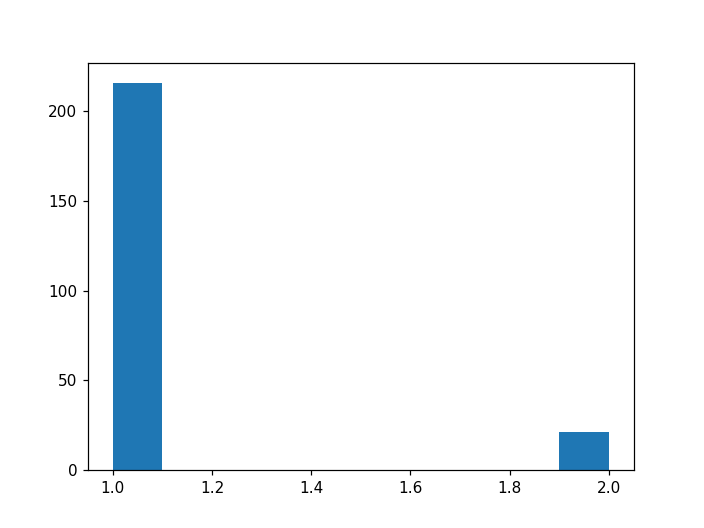

<IPython.core.display.Javascript object>


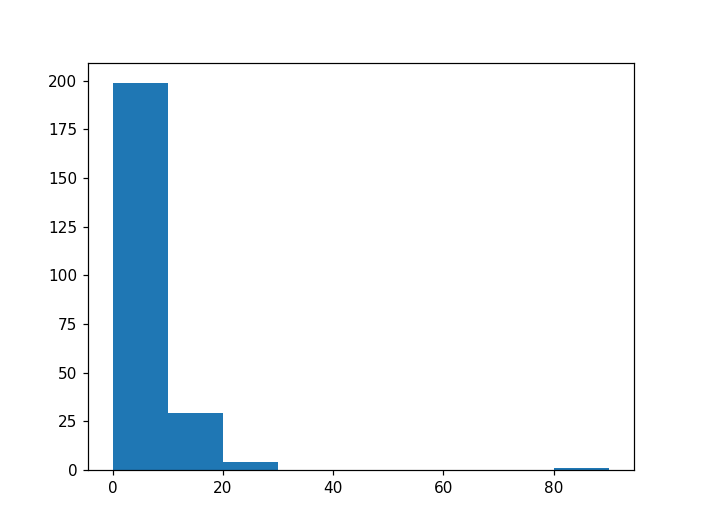

(array([ 199.,   29.,    4.,    0.,    0.,    0.,    0.,    0.,    1.]),
 array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]),
 <a list of 9 Patch objects>)

In [171]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.figure()
plt.hist(hcs)
plt.figure()
plt.hist(scs, bins=range(0,100,10))